Description

This file trains the XGBoost models and examines feature importance. 

New to this code, test years are separated from training and evaluation years according to Gregor et al. (2019)

Inputs

In [1]:
# =========================================
# For accessing directories
# =========================================
#run_dir = "/data/artemis/workspace/vbennington/SOCAT_ML/dpco2/models/reconstructions/xg/fewer_vars1"
#run_dir = "/data/artemis/workspace/vbennington/SOCAT_ML/dpco2/no_atm_seasonality/enso_sst_mon_sample/models"
run_dir = "/data/artemis/workspace/vbennington/SOCAT_ML/pCO2_DIC_Taka/models"
run_dir = "/data/artemis/workspace/vbennington/SOCAT_ML/pco2/models/reconstructions/xg/Gregor1"
run_dir = "/data/artemis/workspace/vbennington/SOCAT_ML/pCO2_DIC/models"
plt_dir = f"{run_dir}/reconstructions/xg/plots"
# =========================================
# Number of cores you have access to for model training
# =========================================
jobs = 30

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import numpy.ma as ma
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'
%config InlineBackend.print_figure_kwargs = {'dpi':300, 'bbox_inches': 'tight'}
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
import matplotlib.pyplot as plt
import scipy
import sklearn.linear_model 
import pickle

Modules

In [4]:
# standard imports
import os
import datetime
from pathlib import Path
from collections import defaultdict
import scipy
import random
import numpy as np
import xarray as xr
import pandas as pd
import joblib
import pickle

# machine learning libraries
import sklearn            # machine-learning libary with many algorithms implemented
import xgboost as xgb     # extreme gradient boosting (XGB
from xgboost import XGBRegressor
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
import sklearn.model_selection as mselect
import shap
# Python file with supporting functions


Predefined Values

In [10]:
# Loading references

In [5]:
# Feature and target lists for feeding into ML
#features_sel = ['sst', 'sst_anom', 'sss', 'sss_anom', 'mld_log', 'chl_log', 'chl_anom', 'pco2_atmos_3d', 'A', 'B', 'C', 'T0', 'T1']
#features_sel = ['sst', 'sss', 'mld_log', 'chl_log', 'xco2', 'enso', 'nao', 'soi', 'A', 'B', 'C', 'T0', 'T1']  # Climate Indices
#features_sel = ['sst', 'sss', 'mld_log', 'chl_log', 'xco2', 'A', 'B', 'C', 'T0', 'T1']  # Fewer Vars
#features_sel = ['sst', 'sss', 'mld_log', 'chl_log', 'xco2', 'enso', 'A', 'B', 'C', 'T0', 'T1']  # ENSO
features_sel = ['sst','sst_anom','sss','sss_anom','chl_log','chl_anom','mld_log','xco2','A','B','C','T0','T1']  # pCO2_DIC
feature_names = ['sst','sst_anom','sss','sss_anom','chl_log','chl_anom','mld_log','xco2','A','B','C','T0','T1'] # pCO2_DIC

#features_sel = ['sst','sst_anom','sss','sss_anom','chl_log','chl_anom','mld_log','xco2','enso','sam','nao','A','B','C','T0','T1'] # pCO2_DIC_indices

#feature_names = ['sst','sss','chl_log','mld_log','pco2_atmos_3d','A','B','C','T0','T1'] # pCO2_DIC_5Clusters
#features_sel = ['sst','sss','chl_log','mld_log','pco2_atmos_3d','A','B','C','T0','T1'] # pCO2_DIC_5Clusters

cmax = [16,3,6,2,10,1,25,20,25,15,15,5,5]
target_sel = ['pco2_weighted']

# Test getting rid of atmospheric pCO2:
#features_sel = ['sst', 'sst_anom', 'sss', 'sss_anom', 'mld_log', 'mld_anom', 'chl_log', 'chl_anom', 'A', 'B', 'C', 'T0', 'T1']
#target_sel = ['dpco2']


In [6]:
approach = 'xg'


In [7]:
print(datetime.datetime.now())

# Initialize SHAP / feature importance times series
fi_series = np.empty(shape=(len(features_sel),2020-1982)) # Times Series of Mean SHAP Impact
        
# Load Saved Model: 
#model_dir = f'{run_dir}/trained/xg'
model_dir = f"{run_dir}"
fname = f"xg_dpCO2_2D_mon_1x1_198201-201912.joblib"
filename = f"{model_dir}/{fname}"
        
model = joblib.load(filename)
print(model)
        
# Data file path
data_dir = f"/data/artemis/workspace/vbennington/SOCAT_ML/pCO2_DIC_Taka/data/processed"
data_dir = f"/data/artemis/workspace/vbennington/SOCAT_ML/pCO2_DIC/data/processed"

#data_dir = f"/data/artemis/workspace/vbennington/SOCAT_ML/pco2/data/processed"
fname = f"data_clean_2D_mon_1x1_198201-201912.pkl"
file_path = f"{data_dir}/{fname}"
        
# Read in data, create some selection filters, produce a reduced dataframe
df = pd.read_pickle(file_path)
#df['enso_sst'] = df['enso']*df['sst']
recon_sel = (~df[features_sel+['net_mask']].isna().any(axis=1))   # Dont' have dpCO2 for non-SOCAT locations, but have features
print(sum(recon_sel))
################################################################################################################################        
#sel = (recon_sel & (df['socat_mask'] == 1)) & ((df[target_sel] < 350) & (df[target_sel] > -350)).to_numpy().ravel()           
# locations not masked AND IN SOCAT SAMPLING and within reason
        
################################################################################################################################        
#nonsocat_sel = (recon_sel & (df['socat_mask'] == 0))      # locations not masked and NOT IN SOCAT SAMPLING
########################################################################################################################
        
# X / Y at unseen locations:
# Where no SOCAT data ONLY ###########
#X_nonsocat = df.loc[nonsocat_sel,features_sel].to_numpy()
X_recon = df.loc[recon_sel,features_sel].to_numpy() 
    
# Shap Importance
print('SHAP start ',datetime.datetime.now())
shap_unseen = shap.TreeExplainer(model).shap_values(X_recon,approximate=True,check_additivity=False)
print('SHAP end ',datetime.datetime.now())
        
df = df.drop(columns=['sss','sss_anom','sst_anom','chl_anom','A','B','C','T0','T1'])
        
i = 0
for feat in features_sel:
    print(feat)
    df[f'{feat}_shap'] = np.nan
    df.loc[recon_sel,[f'{feat}_shap']]=shap_unseen[:,i]
    i += 1
       
    
# features_sel = ['sst','sss','mld_log','chl_log','pco2_atmos_3d','A', 'B', 'C', 'T0', 'T1']    
# Save SHAP findings:
shap_values = df[['sst_shap','sss_shap','mld_log_shap','A_shap','B_shap','C_shap','pco2_atmos_3d_shap','chl_log_shap','T0_shap','T1_shap']].to_xarray()
#shap_values = df[['sst_shap','sst_anom_shap','sss_shap','sss_anom_shap','mld_log_shap','A_shap','B_shap','C_shap','xco2_shap','chl_log_shap','chl_anom_shap','T0_shap','T1_shap']].to_xarray()
#shap_values.to_netcdf(f'{run_dir}/reconstructions/xg/SHAP_values.nc')
shap_values.to_netcdf(f'{run_dir}/SHAP_values.nc')

i = 0
for feat in features_sel:
    fi_series[i,:] = shap_values[f'{feat}_shap'].groupby("time.year").mean("time").mean(['xlon','ylat'])
    i += 1       
                      
# Save Feature Importance Time Series:
series = xr.Dataset({
                    'feature_importance':(["feature","year"],fi_series)
                    },
                    coords={'year': (['year'],range(1982,2020)),
                            'feature':(['feature'],features_sel)
                        })
series.to_netcdf(f'{run_dir}/reconstructions/xg/feature_importance_198201-201912.nc') 
#series.to_netcdf(f'{run_dir}/feature_importance_198201-201912.nc') 

2021-09-03 16:31:11.469060
XGBRegressor(max_depth=6, missing=nan, n_estimators=2000, n_jobs=30,
             random_state=12)
15430878
SHAP start  2021-09-03 16:31:37.035006


ValueError: This reshape error is often caused by passing a bad data matrix to SHAP. See https://github.com/slundberg/shap/issues/580

In [10]:
df.columns

Index(['sss', 'sst', 'chl', 'pco2_weighted', 'socat_mask', 'pco2_atmos_3d',
       'mld', 'mld_log', 'mld_anom', 'chl_log', 'chl_anom', 'sss_anom',
       'sst_anom', 'T0', 'T1', 'A', 'B', 'C', 'net_mask'],
      dtype='object')

In [8]:
shap_values = xr.open_dataset(f'{run_dir}/reconstructions/xg/SHAP_values.nc')

In [9]:
shap_series = xr.open_dataset(f'{run_dir}/reconstructions/xg/feature_importance_198201-201912.nc')

In [14]:
print(shap_series)

<xarray.Dataset>
Dimensions:             (feature: 13, year: 38)
Coordinates:
  * year                (year) int64 1982 1983 1984 1985 ... 2016 2017 2018 2019
  * feature             (feature) object 'sst' 'sst_anom' 'sss' ... 'T0' 'T1'
Data variables:
    feature_importance  (feature, year) float64 ...


In [17]:
run2_dir = "/data/artemis/workspace/vbennington/SOCAT_ML/dpco2/no_atm_seasonality/fewer_vars/models"
old_shap_series = xr.open_dataset(f'{run2_dir}/reconstructions/xg/feature_importance_198201-201912.nc')
old_shap_values = xr.open_dataset(f'{run2_dir}/reconstructions/xg/SHAP_values.nc')

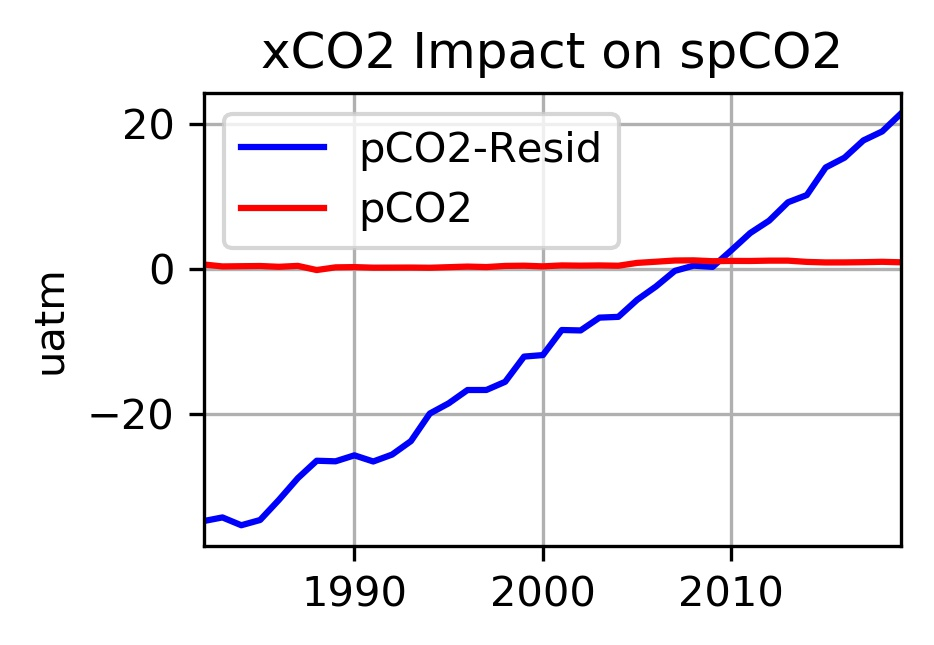

In [27]:
fig = plt.figure(figsize=(3,2))
plt.plot(shap_series.year,shap_series.feature_importance[7,:],'blue',label='pCO2-Resid')
plt.plot(shap_series.year,old_shap_series.feature_importance[7,:],'red',label='pCO2')
plt.grid(True)
plt.legend()
plt.xlim(1982,2019)
plt.ylabel("uatm")
plt.title("xCO2 Impact on spCO2")
fig.savefig(f"{plt_dir}/compare_xCO2_FI.eps")    

In [1]:
for i in range(0,len(features_sel)):
    fig,ax = plt.subplots(1,2,figsize=(16,4))
    x0=ax[0].contourf(shap_values.xlon,shap_values.ylat,shap_values[f"{features_sel[i]}_shap"].mean("time").transpose(),cmap='jet',levels=np.linspace(-cmax[i],cmax[i],11))
    x1=ax[1].plot(shap_values.time,shap_values[f"{features_sel[i]}_shap"][:,20,90],color='red')
    plt.colorbar(x0,ax=ax[0])
    x2=ax[1].plot(shap_values.time,shap_values[f"{features_sel[i]}_shap"][:,20,30],color='blue')
    x3=ax[1].plot(shap_values.time,shap_values[f"{features_sel[i]}_shap"][:,20,140],color="green")
    x4=ax[1].plot(shap_values.time,shap_values[f"{features_sel[i]}_shap"][:,130,150],color='black')
    ax[1].legend(['Eq Pac','S Ocean','N Pac','N Atl'])
    ax[0].title.set_text(f"SOCAT {features_sel[i]}")
    #fig.savefig(f'{plt_dir}/SOCAT_{features_sel[i]}_FI_map_timeseries.jpg')
    #plt.show()
#plt.colorbar(x3,ax=axs[7,0])
#axs[7,0].title.set_text("SOCAT SOI FI")


#plt.show()

NameError: name 'features_sel' is not defined

AttributeError: 'DataArray' object has no attribute 'apply'

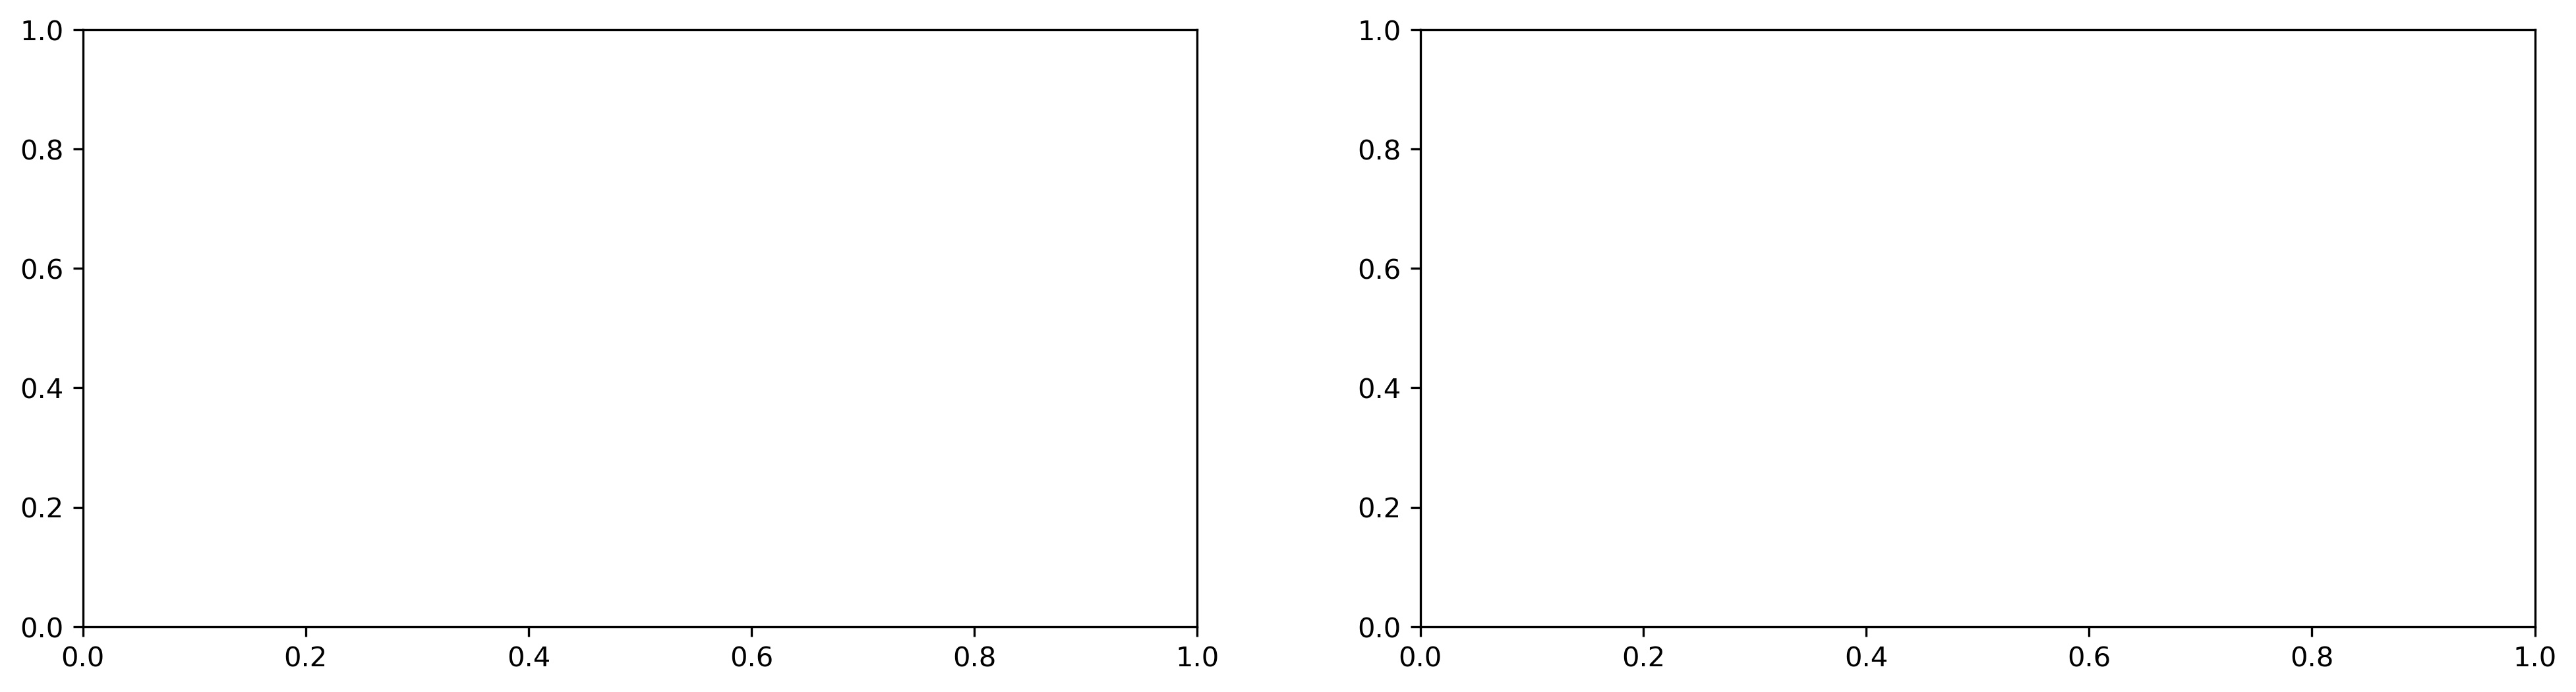

In [70]:
for i in range(0,len(features_sel)):
    fig,ax = plt.subplots(1,2,figsize=(16,4))
    x0=ax[0].contourf(shap_values.xlon,shap_values.ylat,shap_values[f"{features_sel[i]}_shap"].apply(np.fabs).mean("time").transpose(),cmap='jet',levels=np.linspace(0,cmax[i],11))
    x1=ax[1].plot(shap_values.time,shap_values[f"{features_sel[i]}_shap"][:,20,90],color='red')
    plt.colorbar(x0,ax=ax[0])
    x2=ax[1].plot(shap_values.time,shap_values[f"{features_sel[i]}_shap"][:,20,30],color='blue')
    x3=ax[1].plot(shap_values.time,shap_values[f"{features_sel[i]}_shap"][:,20,140],color="green")
    x4=ax[1].plot(shap_values.time,shap_values[f"{features_sel[i]}_shap"][:,130,150],color='black')
    ax[1].legend(['Eq Pac','S Ocean','N Pac','N Atl'])
    ax[0].title.set_text(f"|SOCAT {features_sel[i]}|")
    fig.savefig(f'{plt_dir}/SOCAT_ABS_{features_sel[i]}_FI_map_timeseries.jpg')
    plt.show()

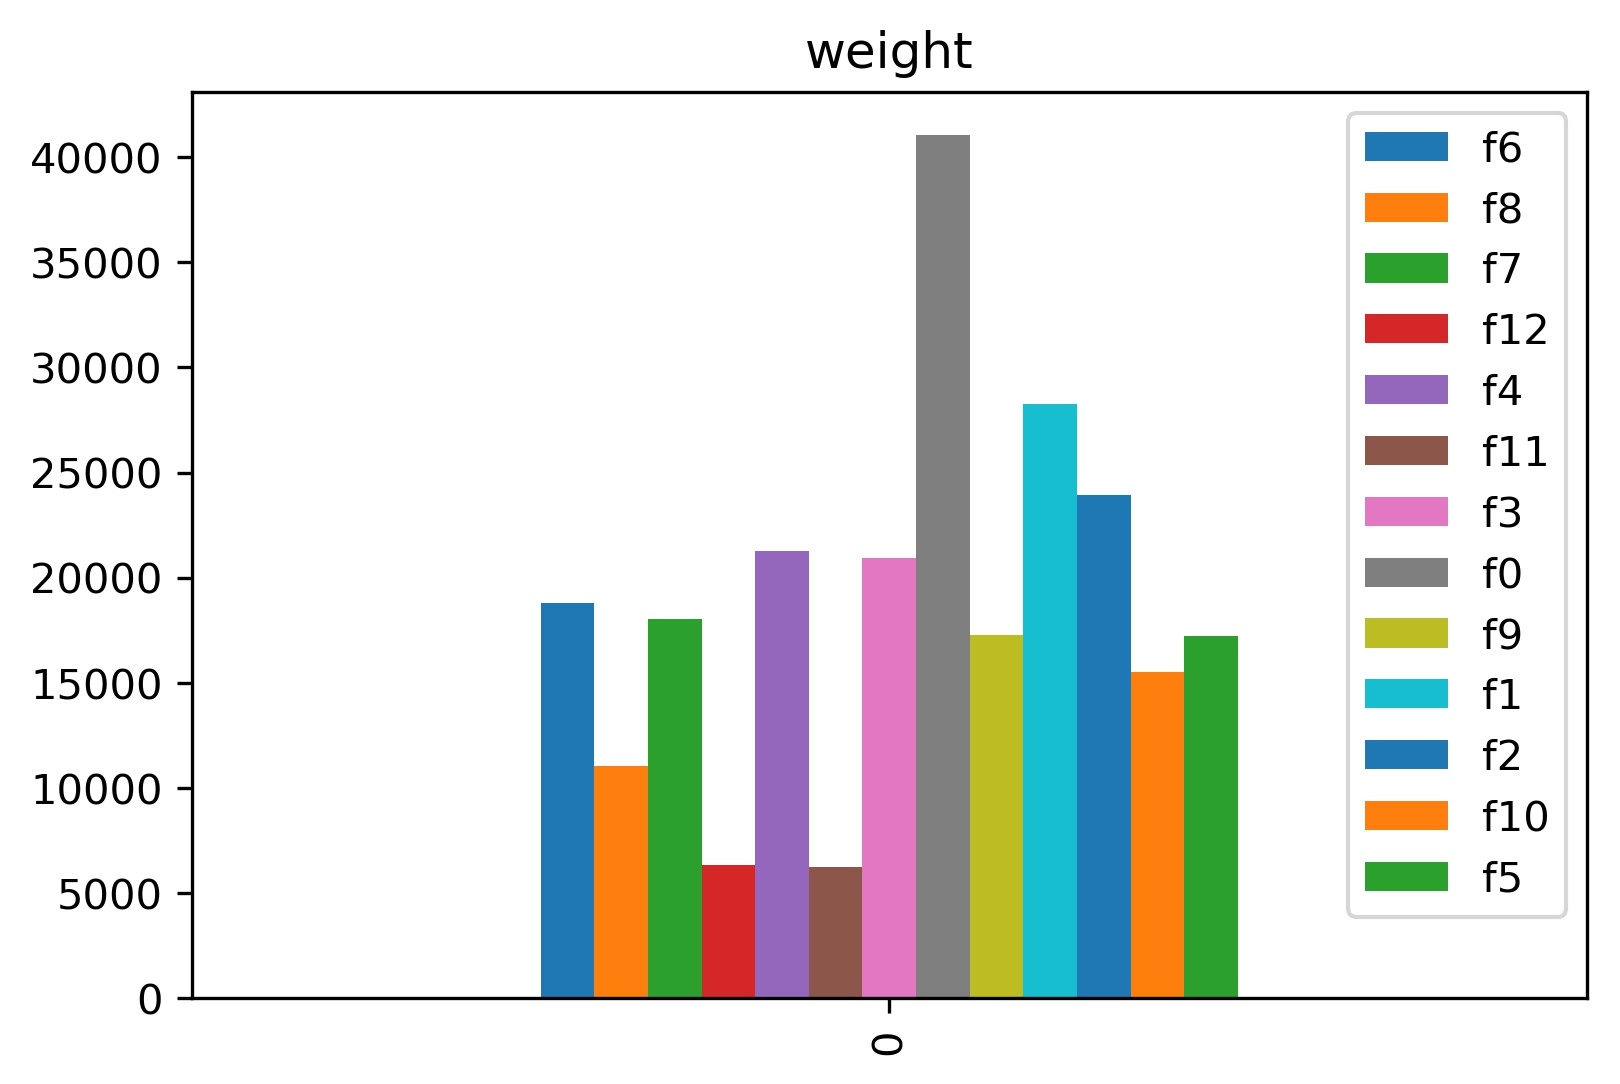

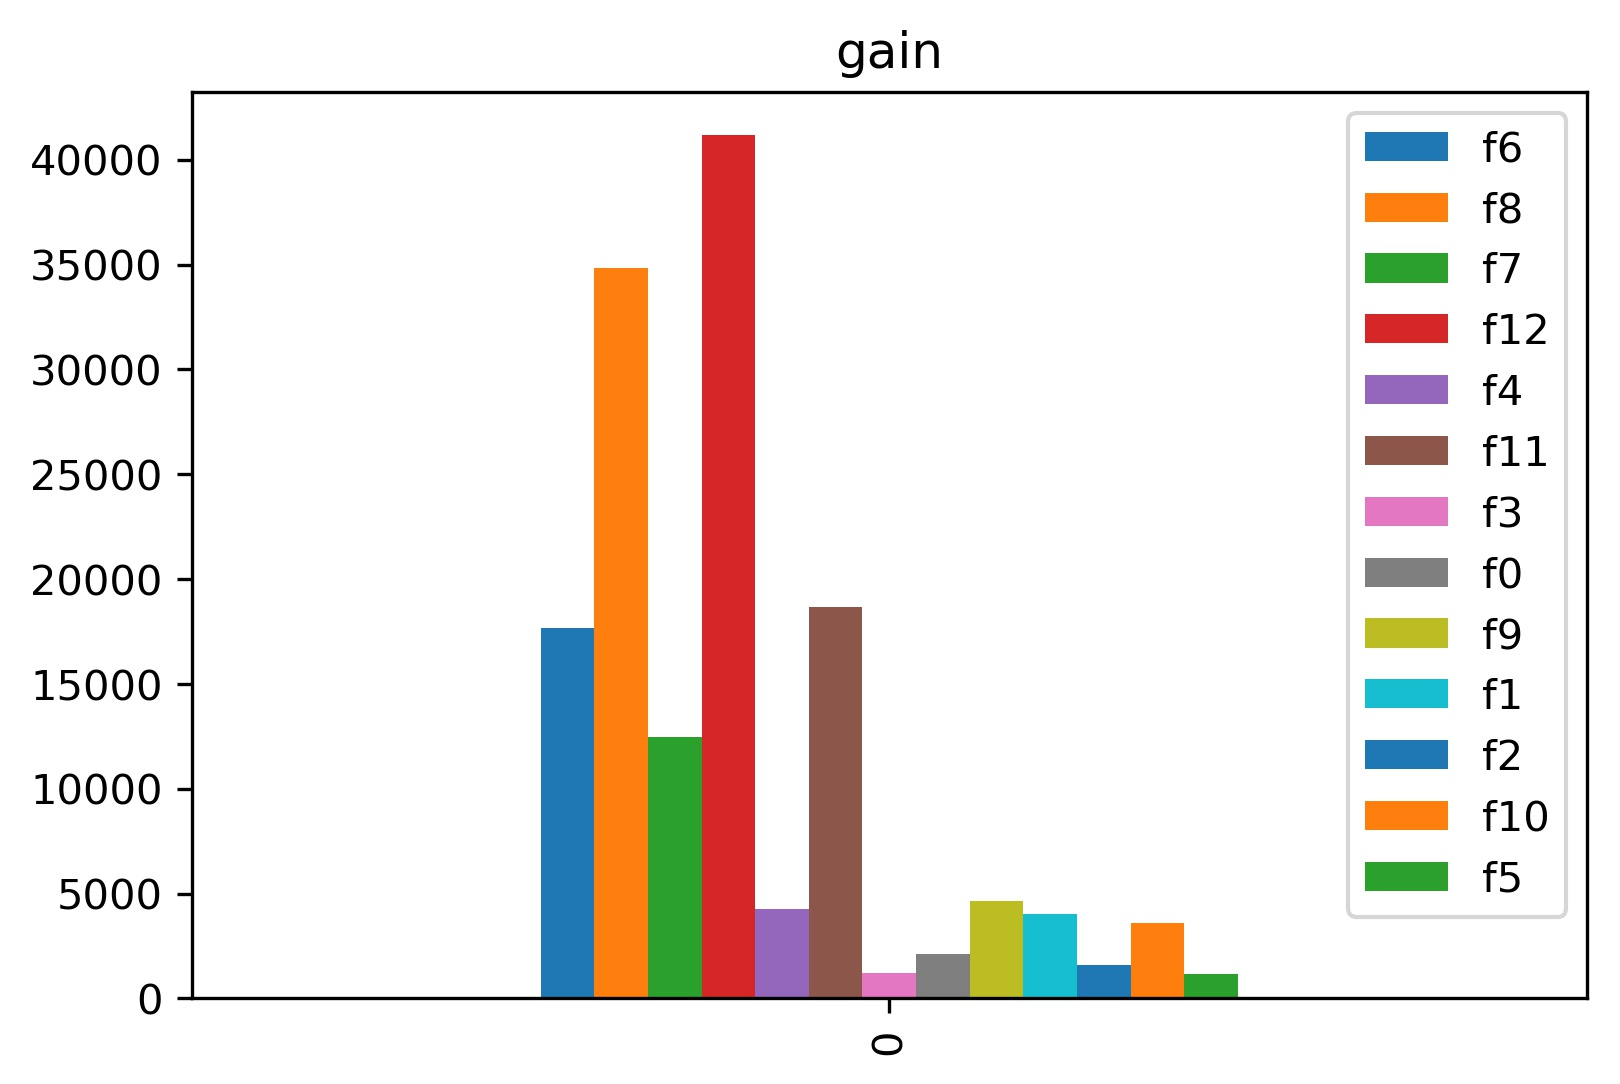

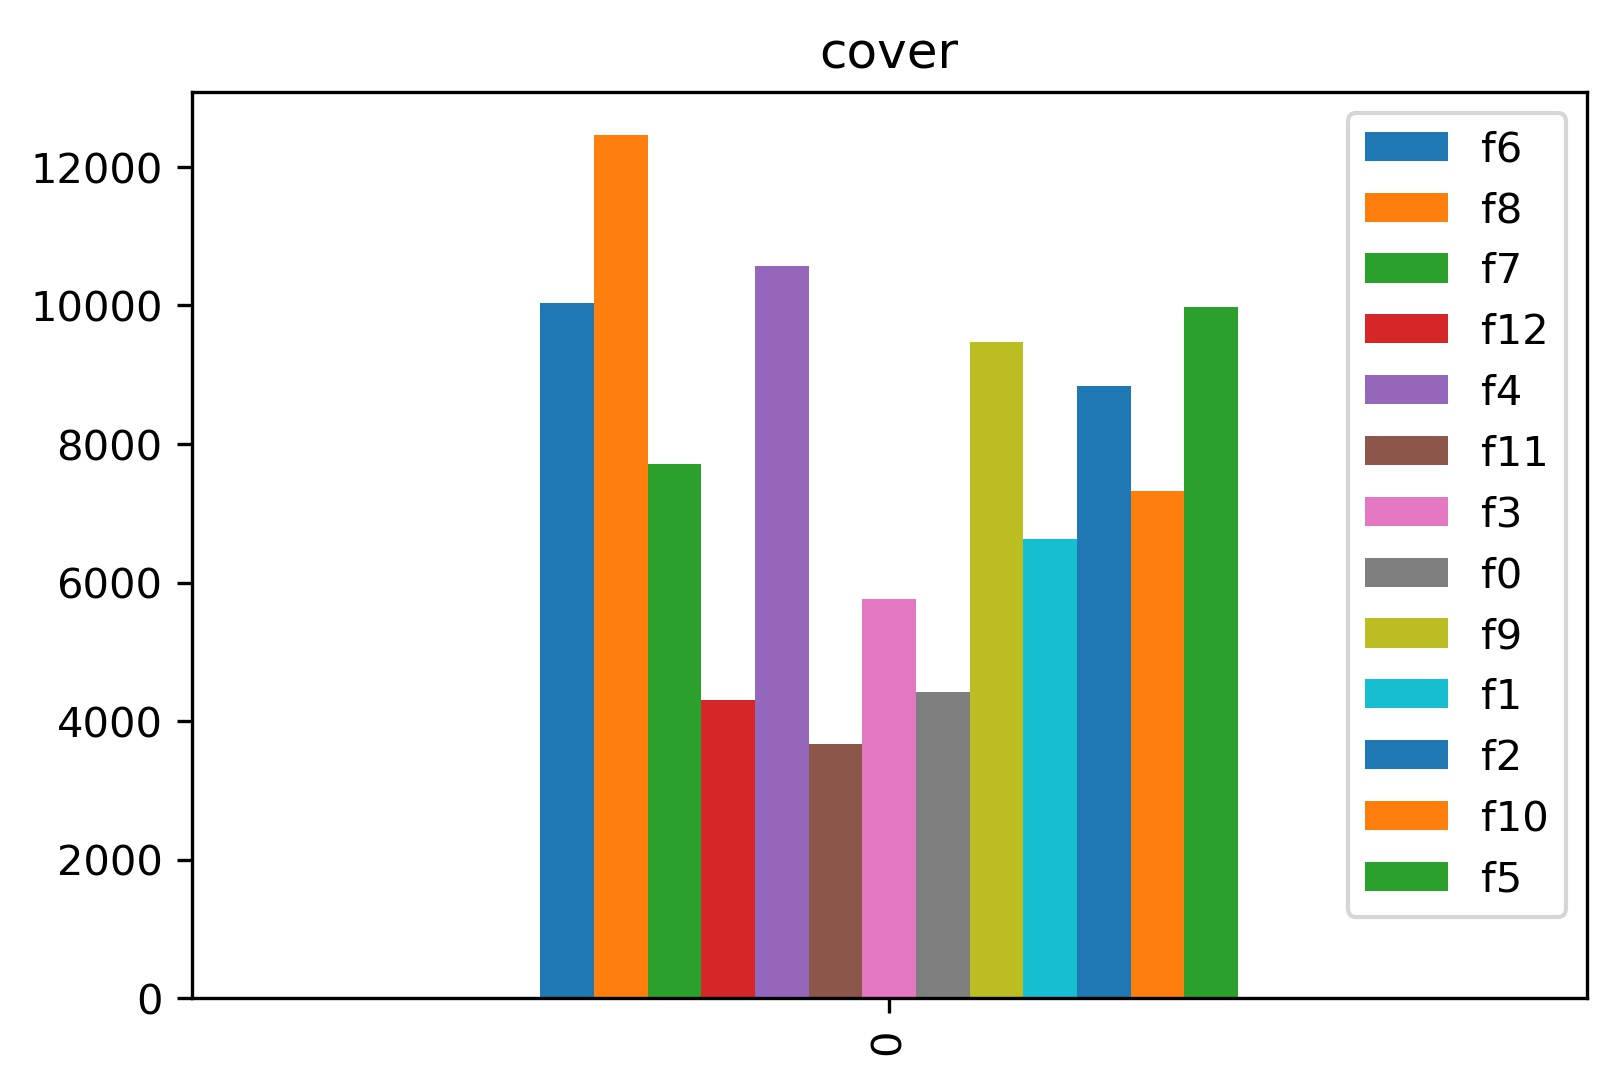

In [26]:
#fig,axs=plt.subplots(1,3,figsize=(20,5))
i=0
for type in ['weight', 'gain', 'cover']:
    #model.get_booster().feature_names=feature_names
    #print(f"{type}", model.get_booster().get_score(importance_type=type))
    ds = pd.DataFrame(model.get_booster().get_score(importance_type=type),index=[0])
    ax = ds.plot.bar()
    ax.set_title(f"{type}")
    i+=1

In [17]:
import shap

In [18]:
shap_values = shap.TreeExplainer(model).shap_values(X_recon,approximate=True)

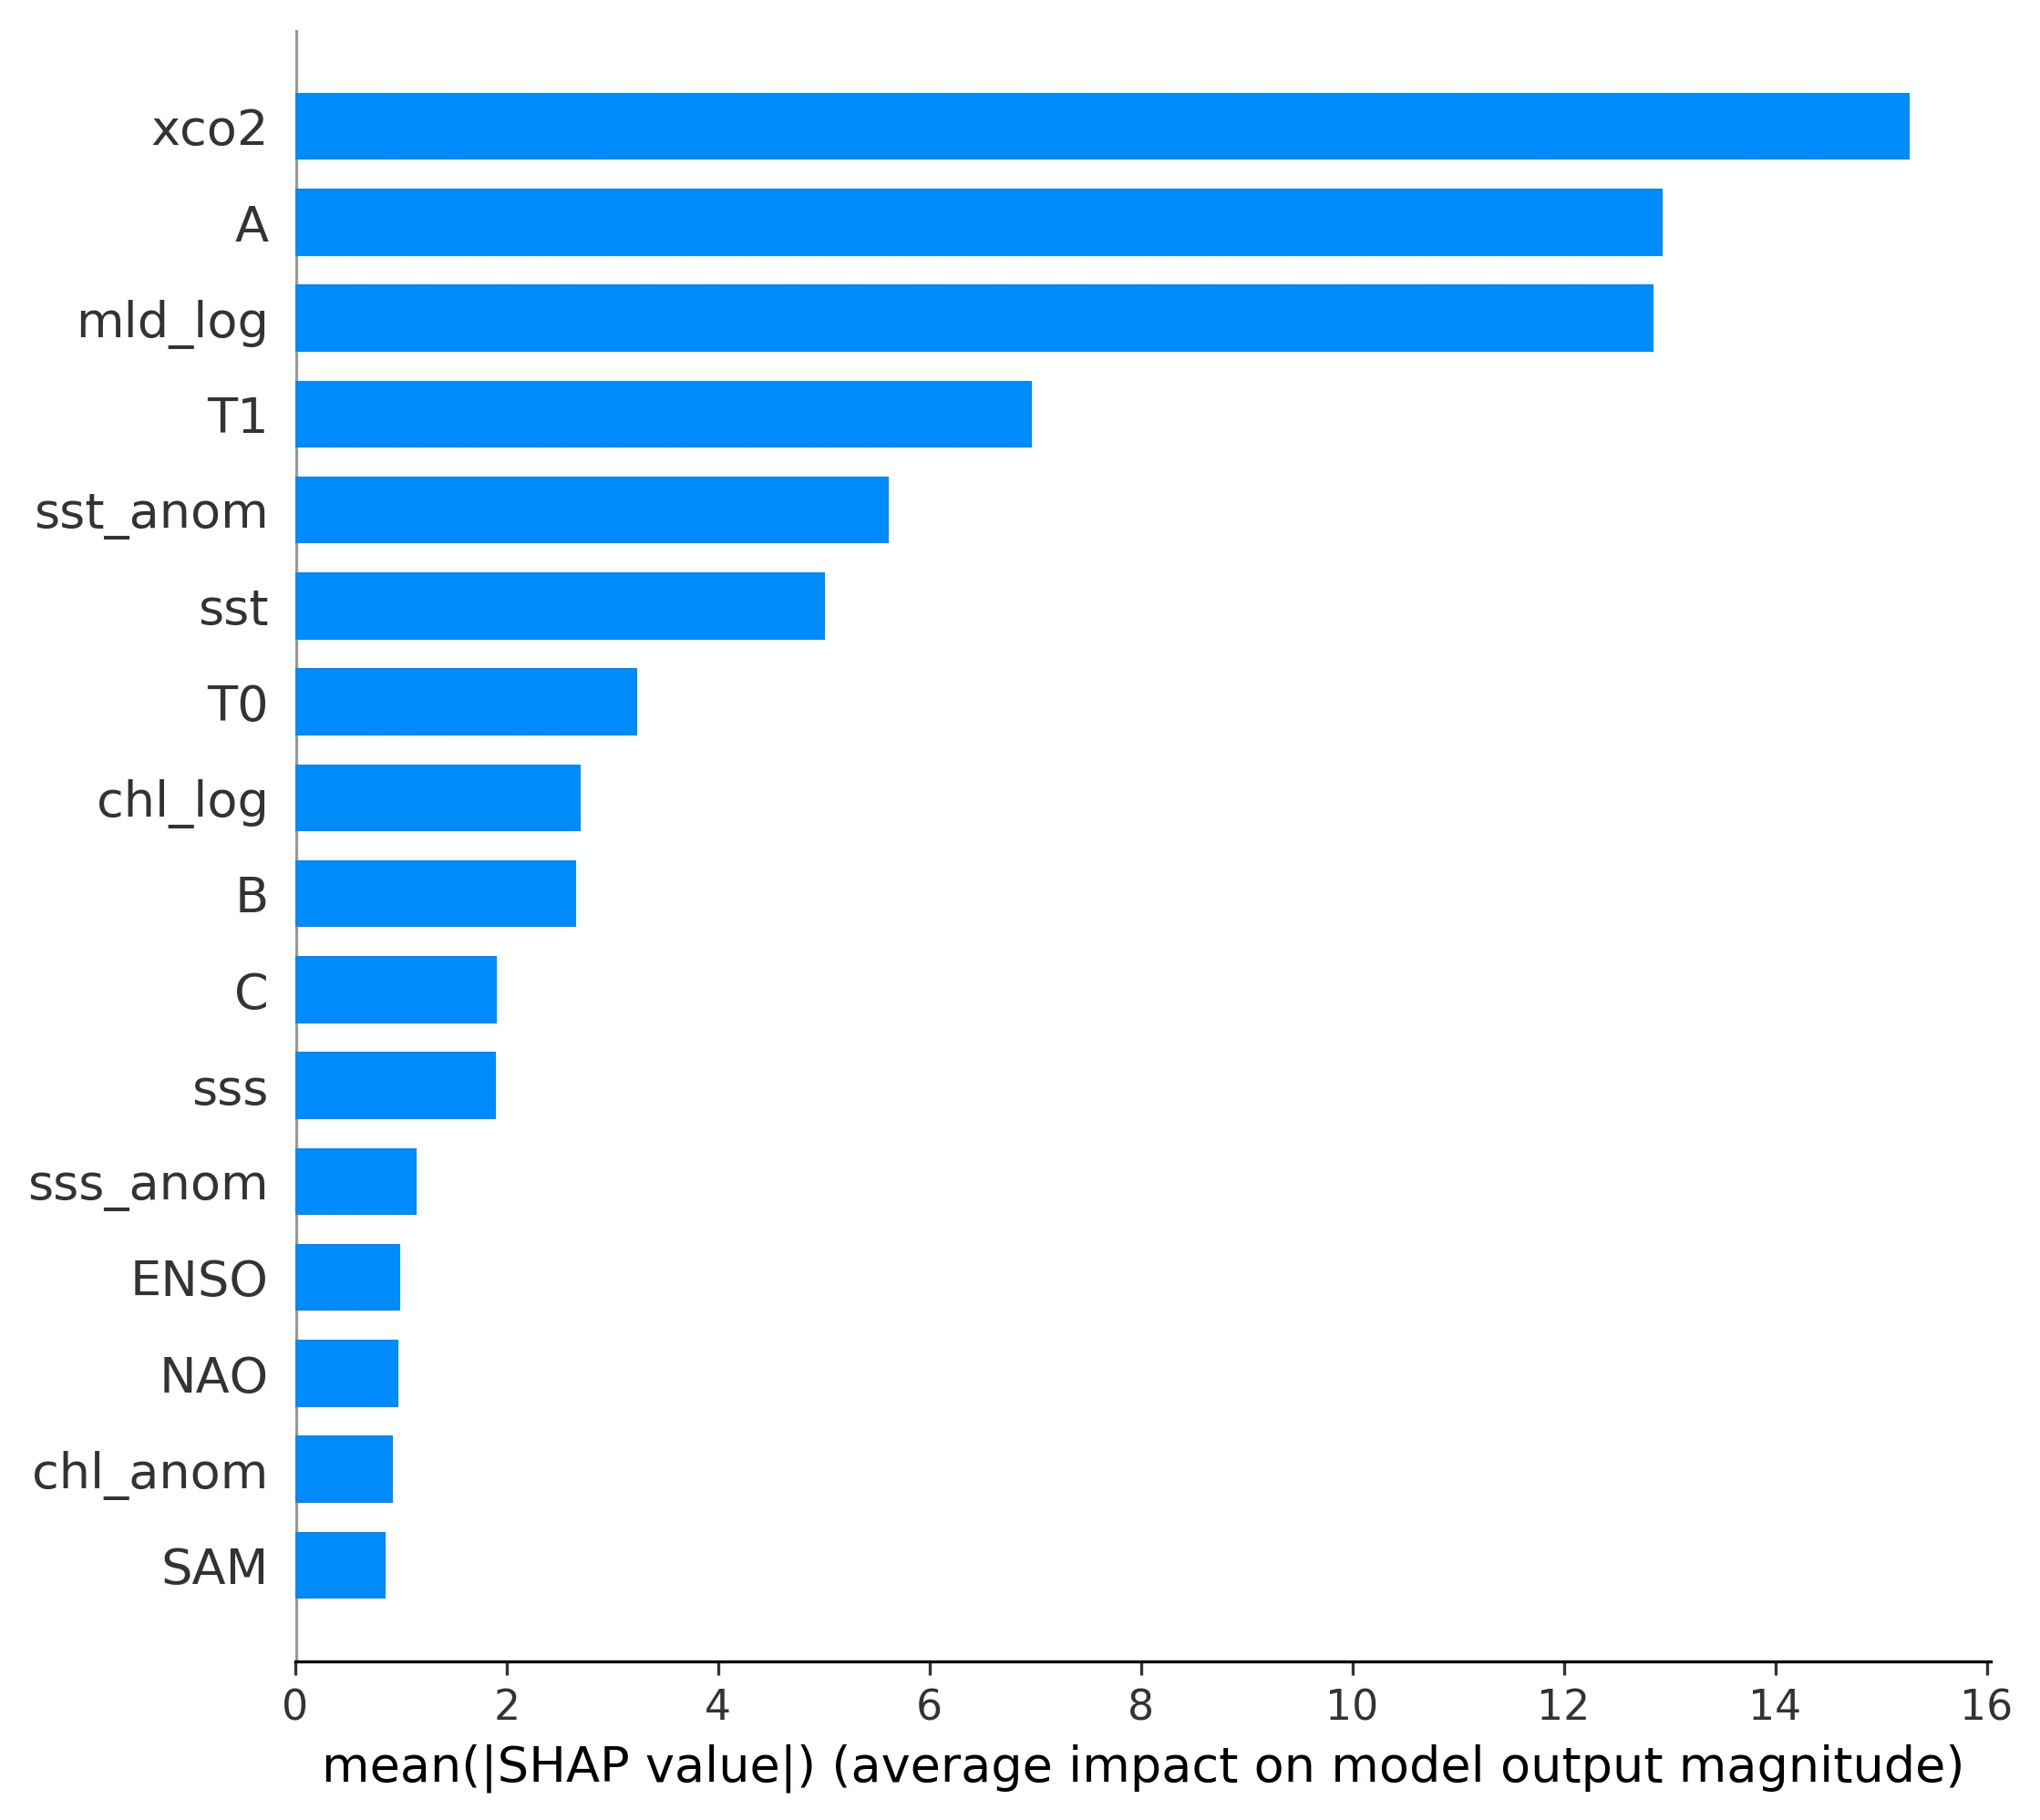

In [71]:
shap.summary_plot(shap_valeus, X_recon, plot_type="bar",feature_names = feature_names)

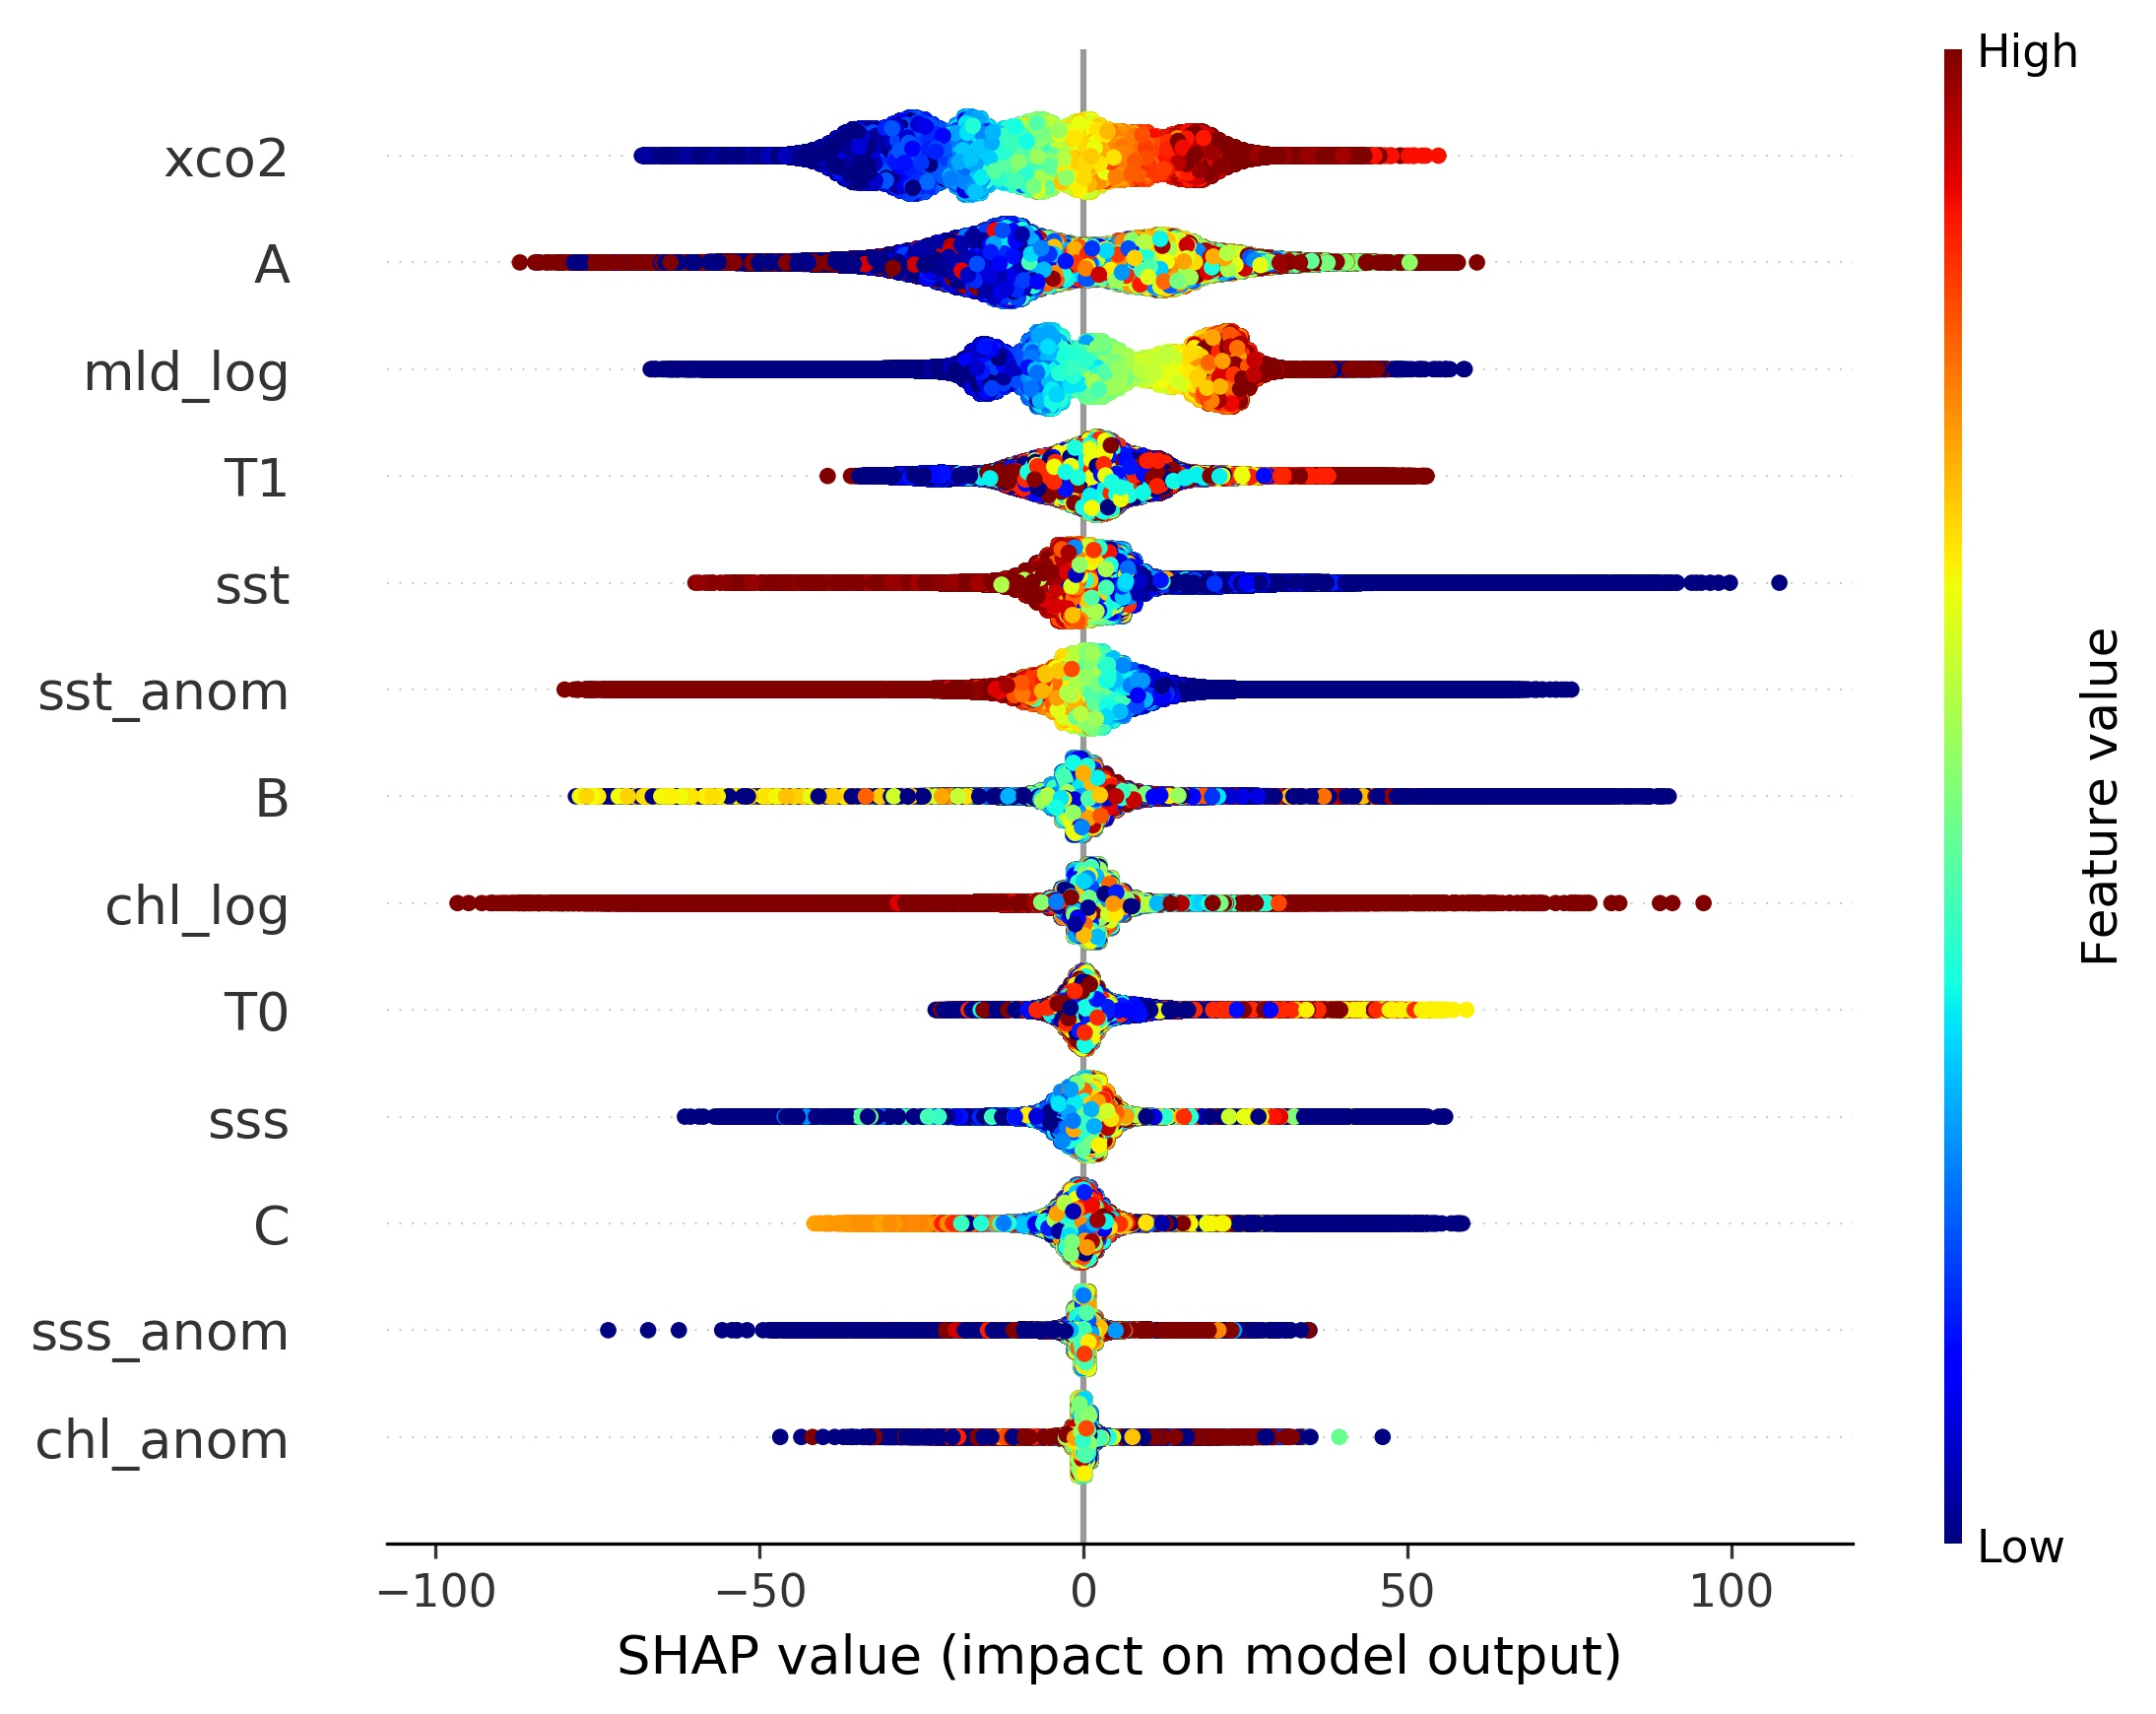

In [23]:
f = plt.figure()
shap.summary_plot(shap_values, X_recon, feature_names = feature_names,cmap='jet',show=False)
#f.savefig(f"{plt_dir}/SOCAT_SHAP_summary_plot.eps", dpi=600)
plt.show()

In [46]:
print(feature_names)

['SST', 'SSS', 'Log(MLD)', 'Chl', 'xCO2', 'A', 'B', 'C', 'T0', 'T1']


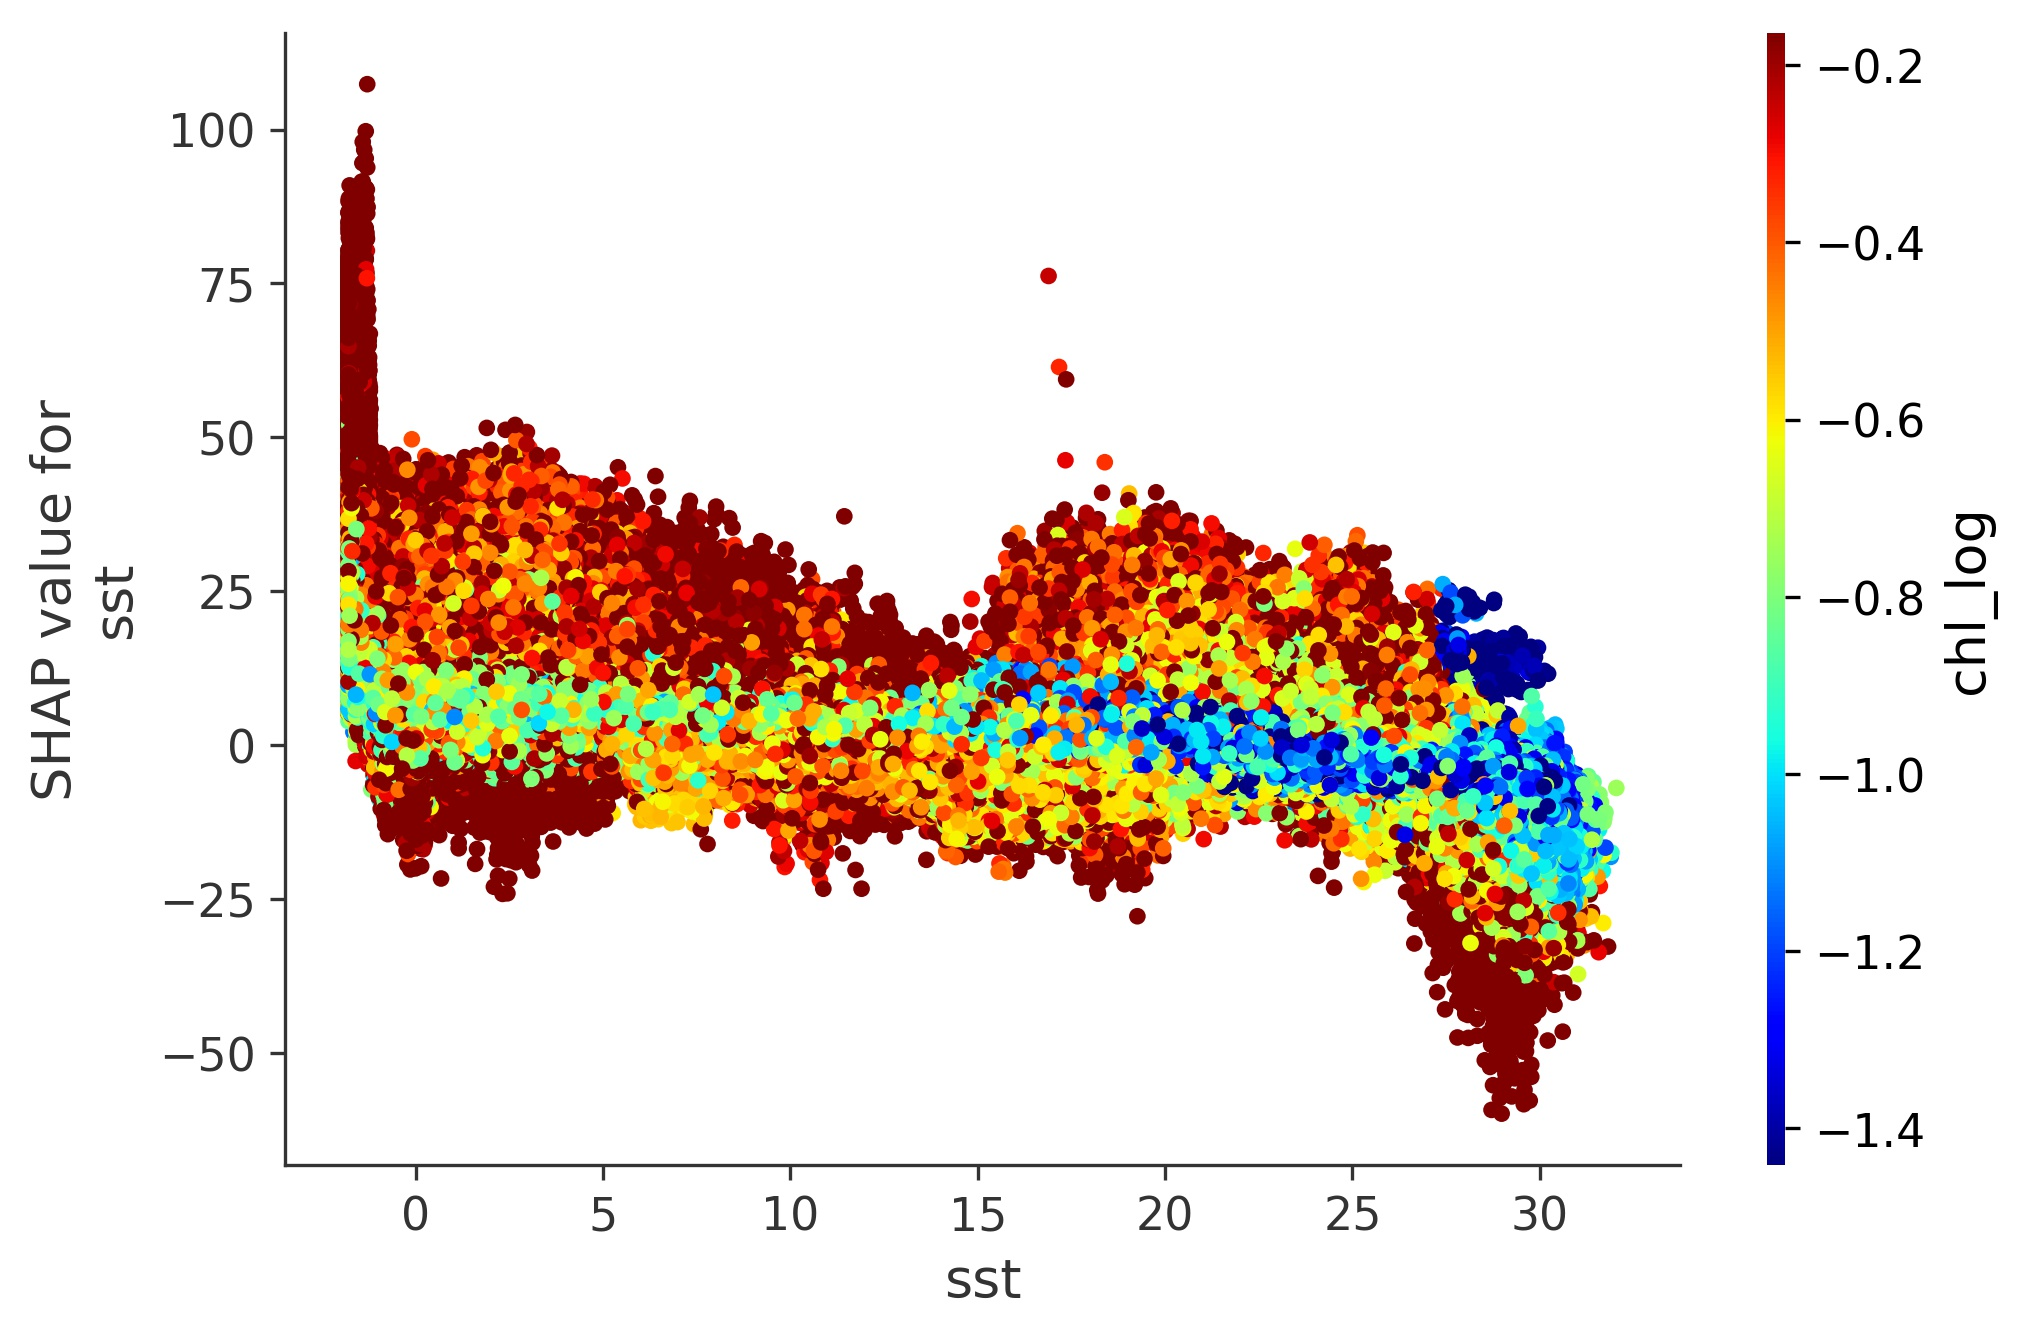

In [24]:
shap.dependence_plot(0, shap_unseen, X_recon,feature_names=feature_names,cmap='jet')

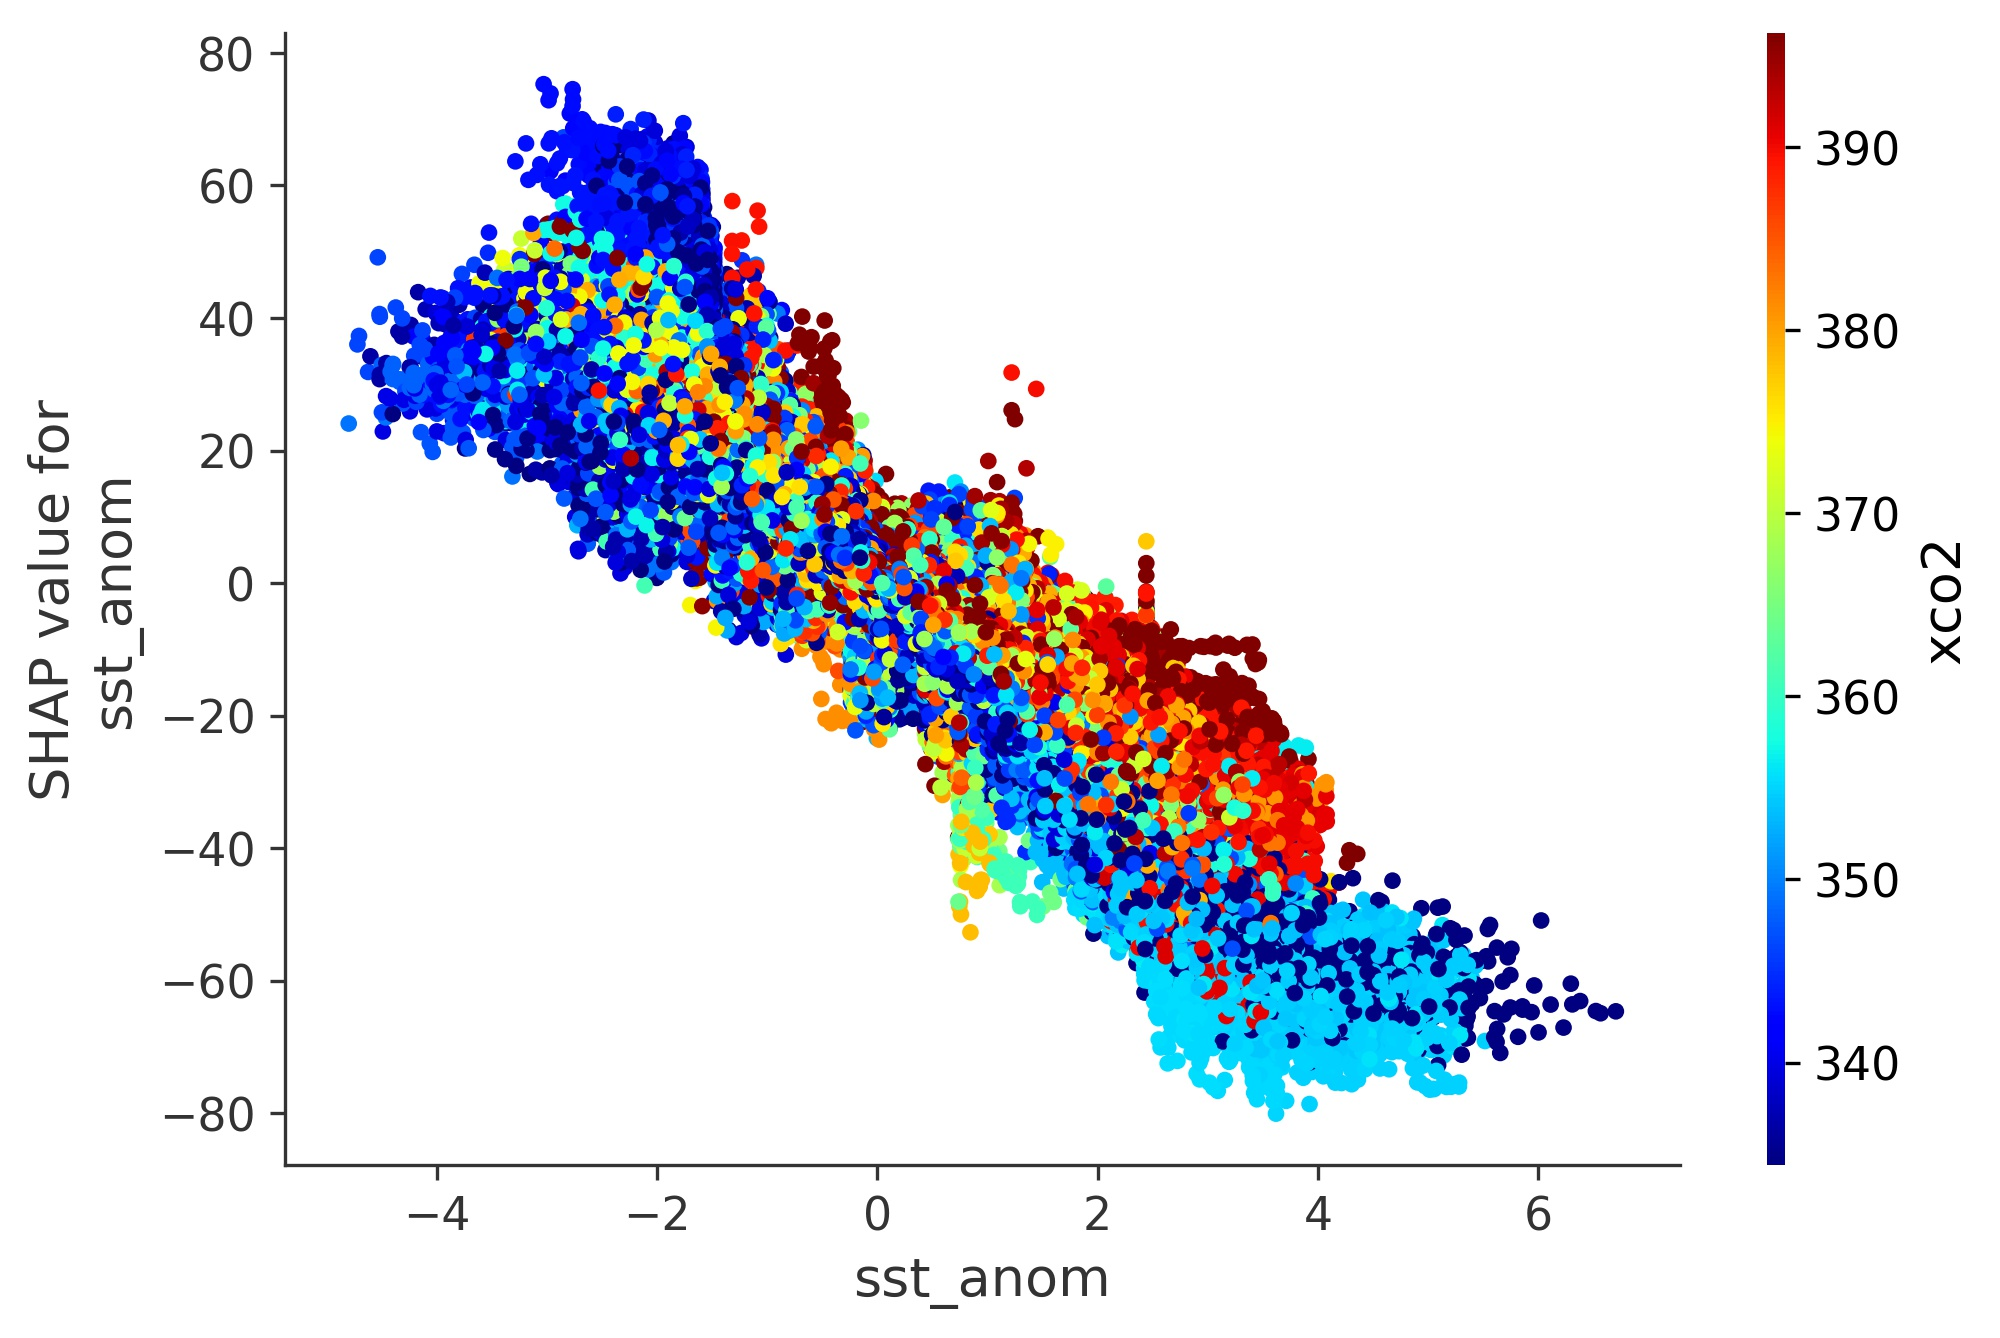

In [25]:
shap.dependence_plot(1, shap_unseen, X_recon,feature_names=feature_names,cmap='jet')

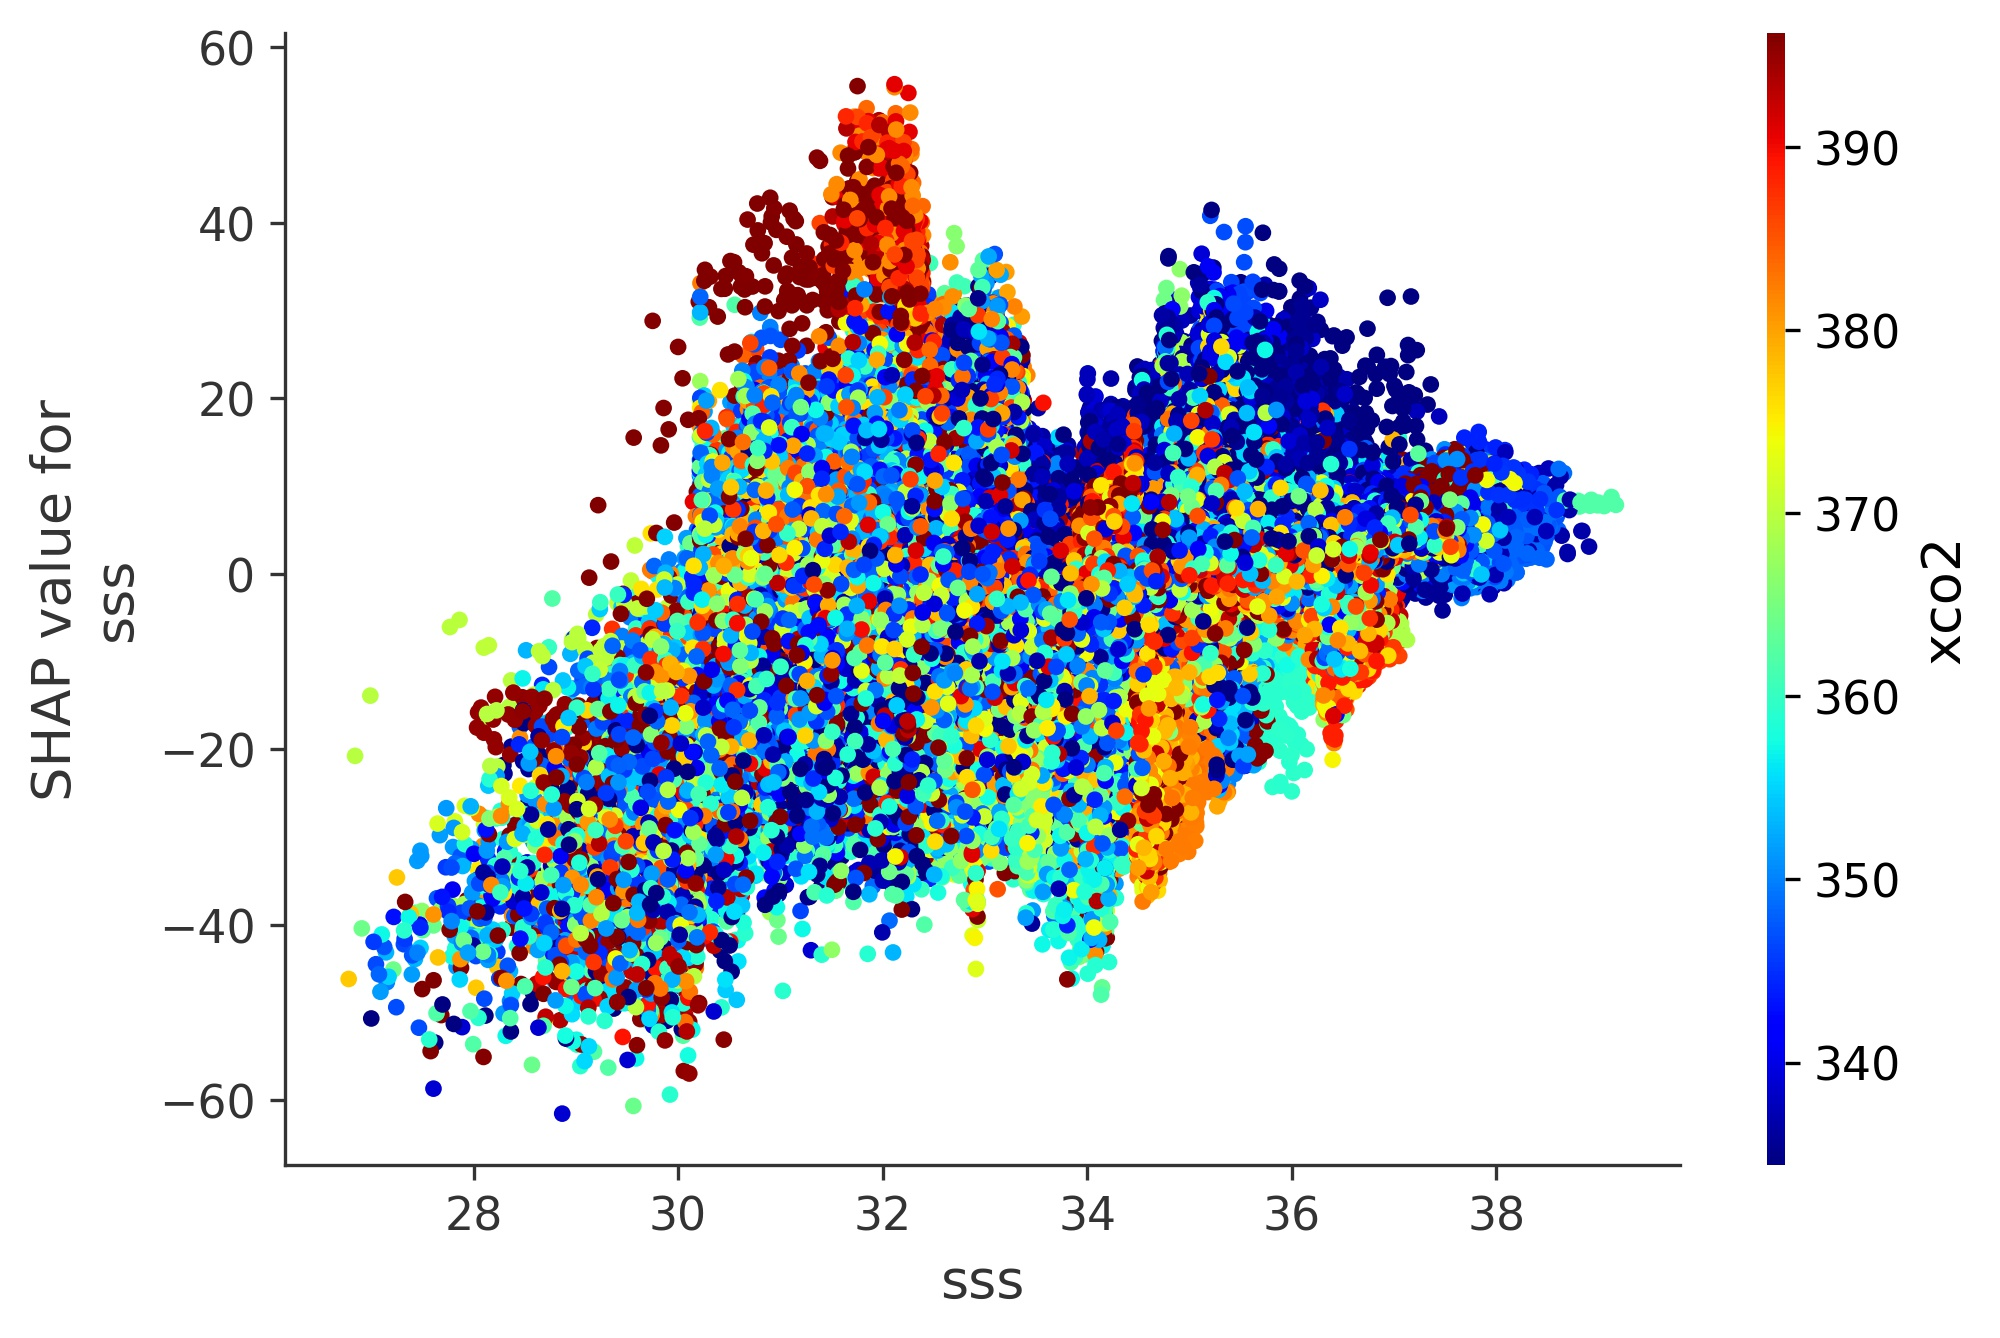

In [26]:
shap.dependence_plot(2, shap_unseen, X_recon,feature_names=feature_names,cmap='jet')

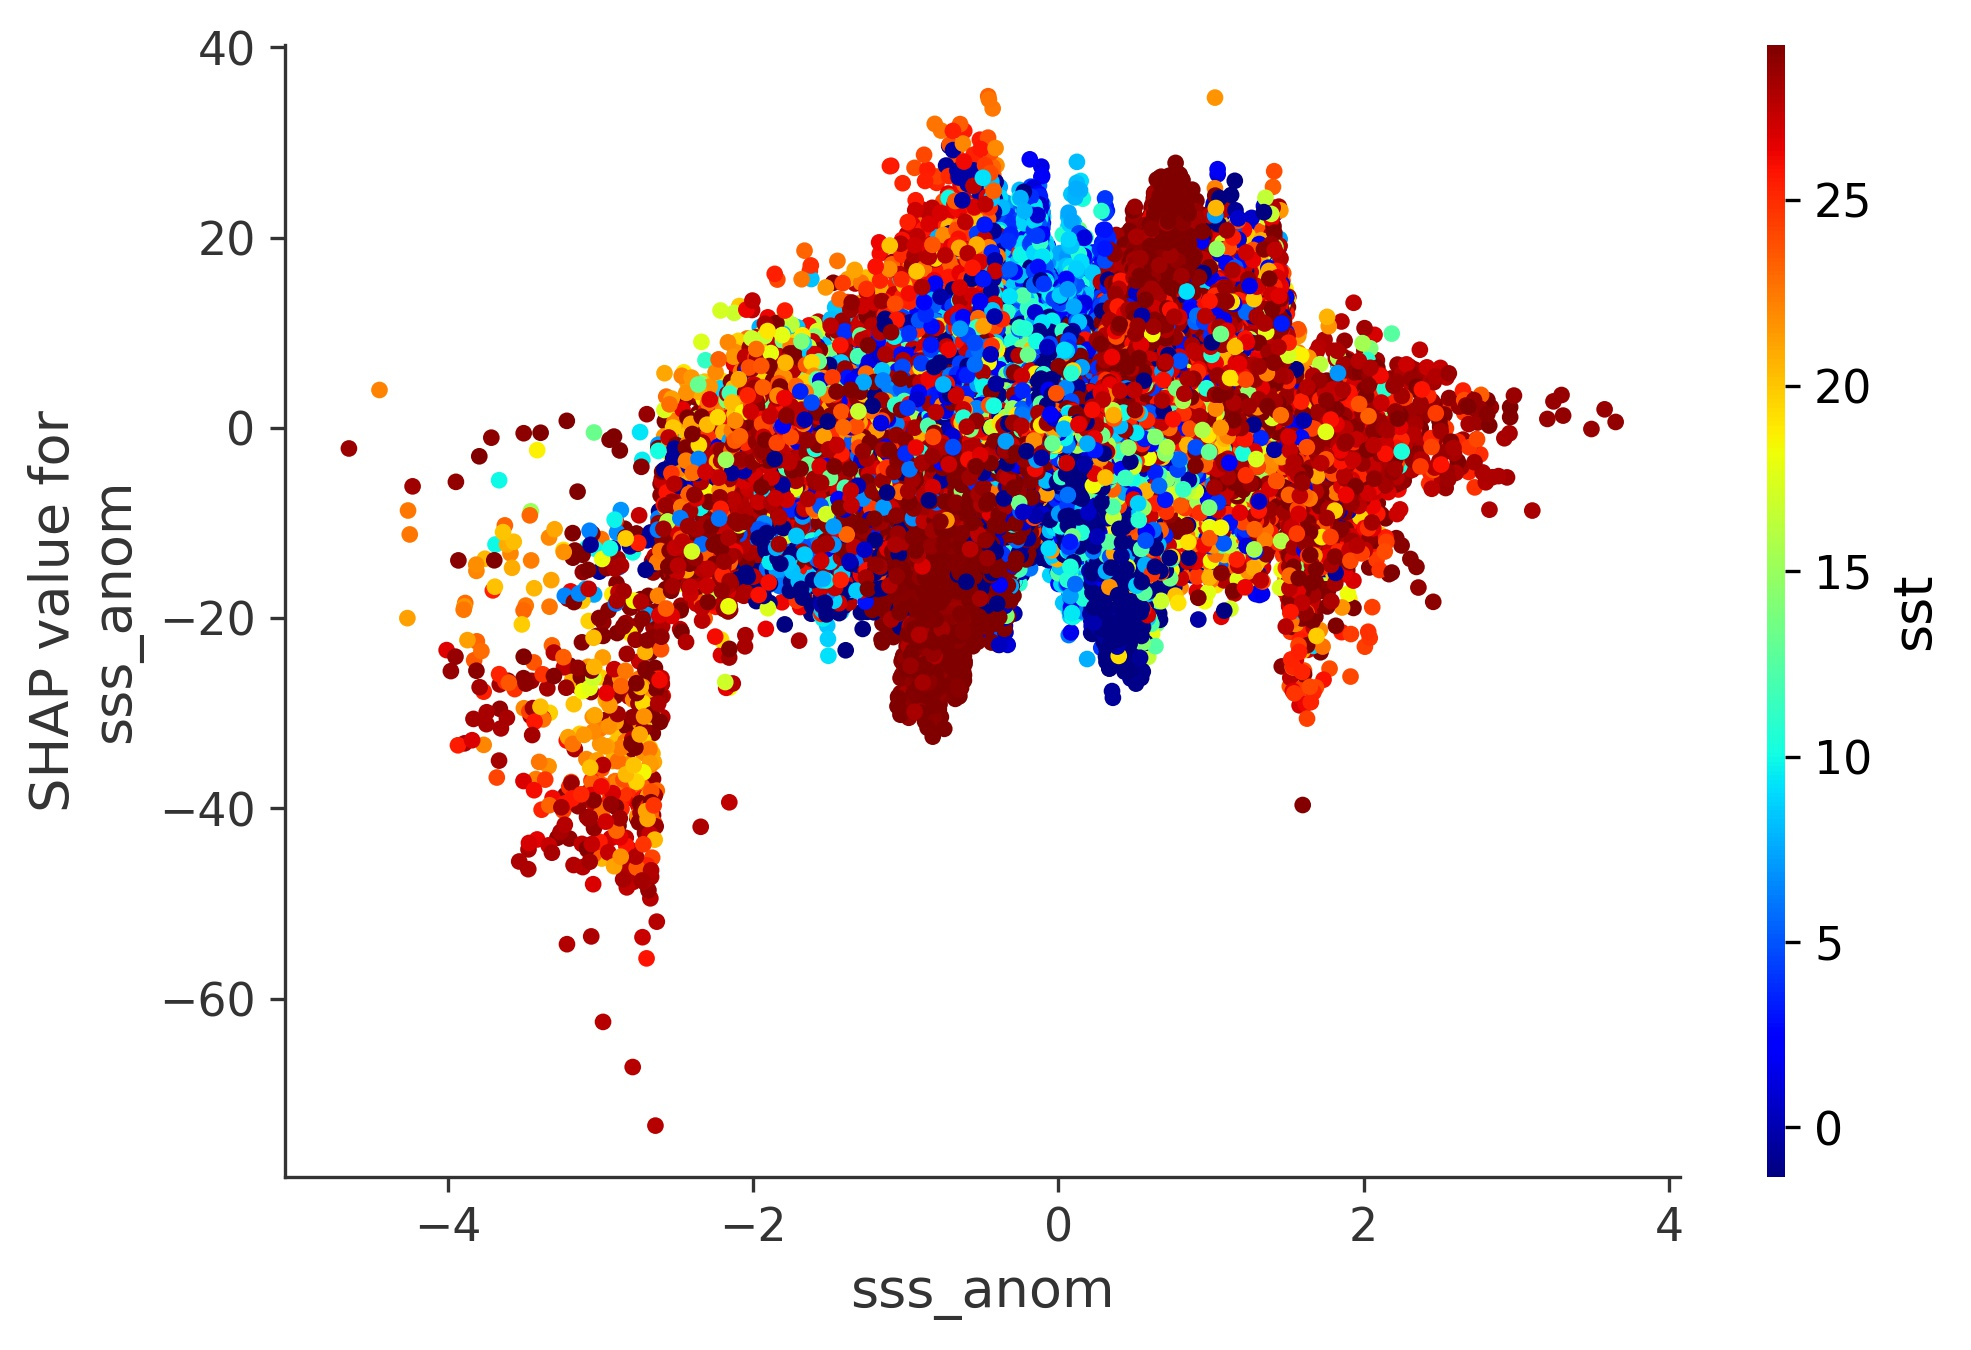

In [27]:
shap.dependence_plot(3, shap_unseen, X_recon,feature_names=feature_names,cmap='jet')

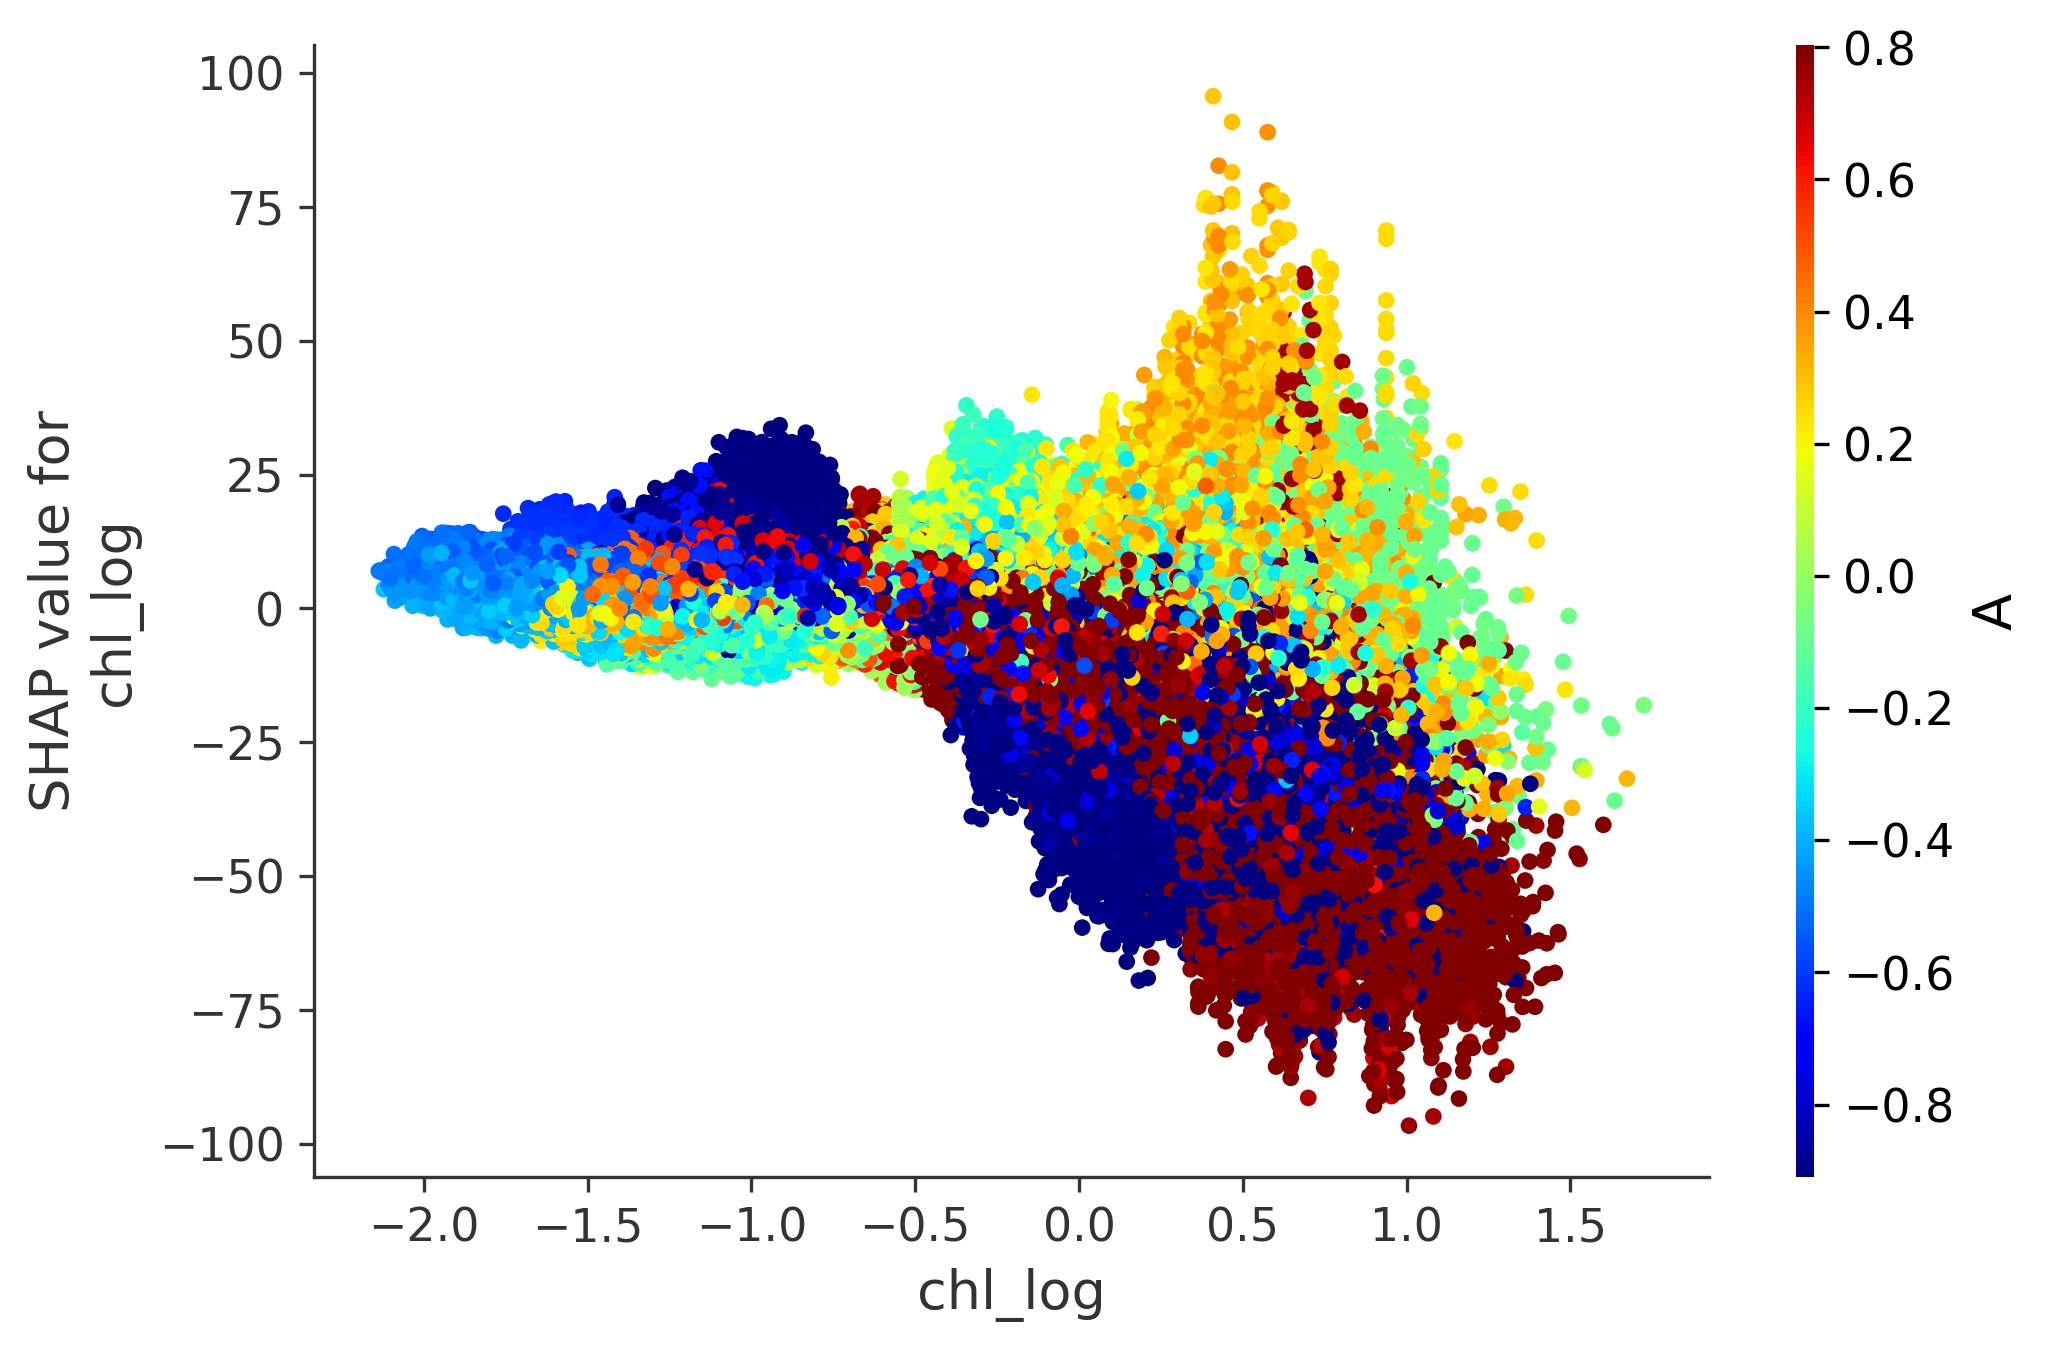

In [28]:
shap.dependence_plot(4, shap_unseen, X_recon,feature_names=feature_names,cmap='jet',interaction_index="A")

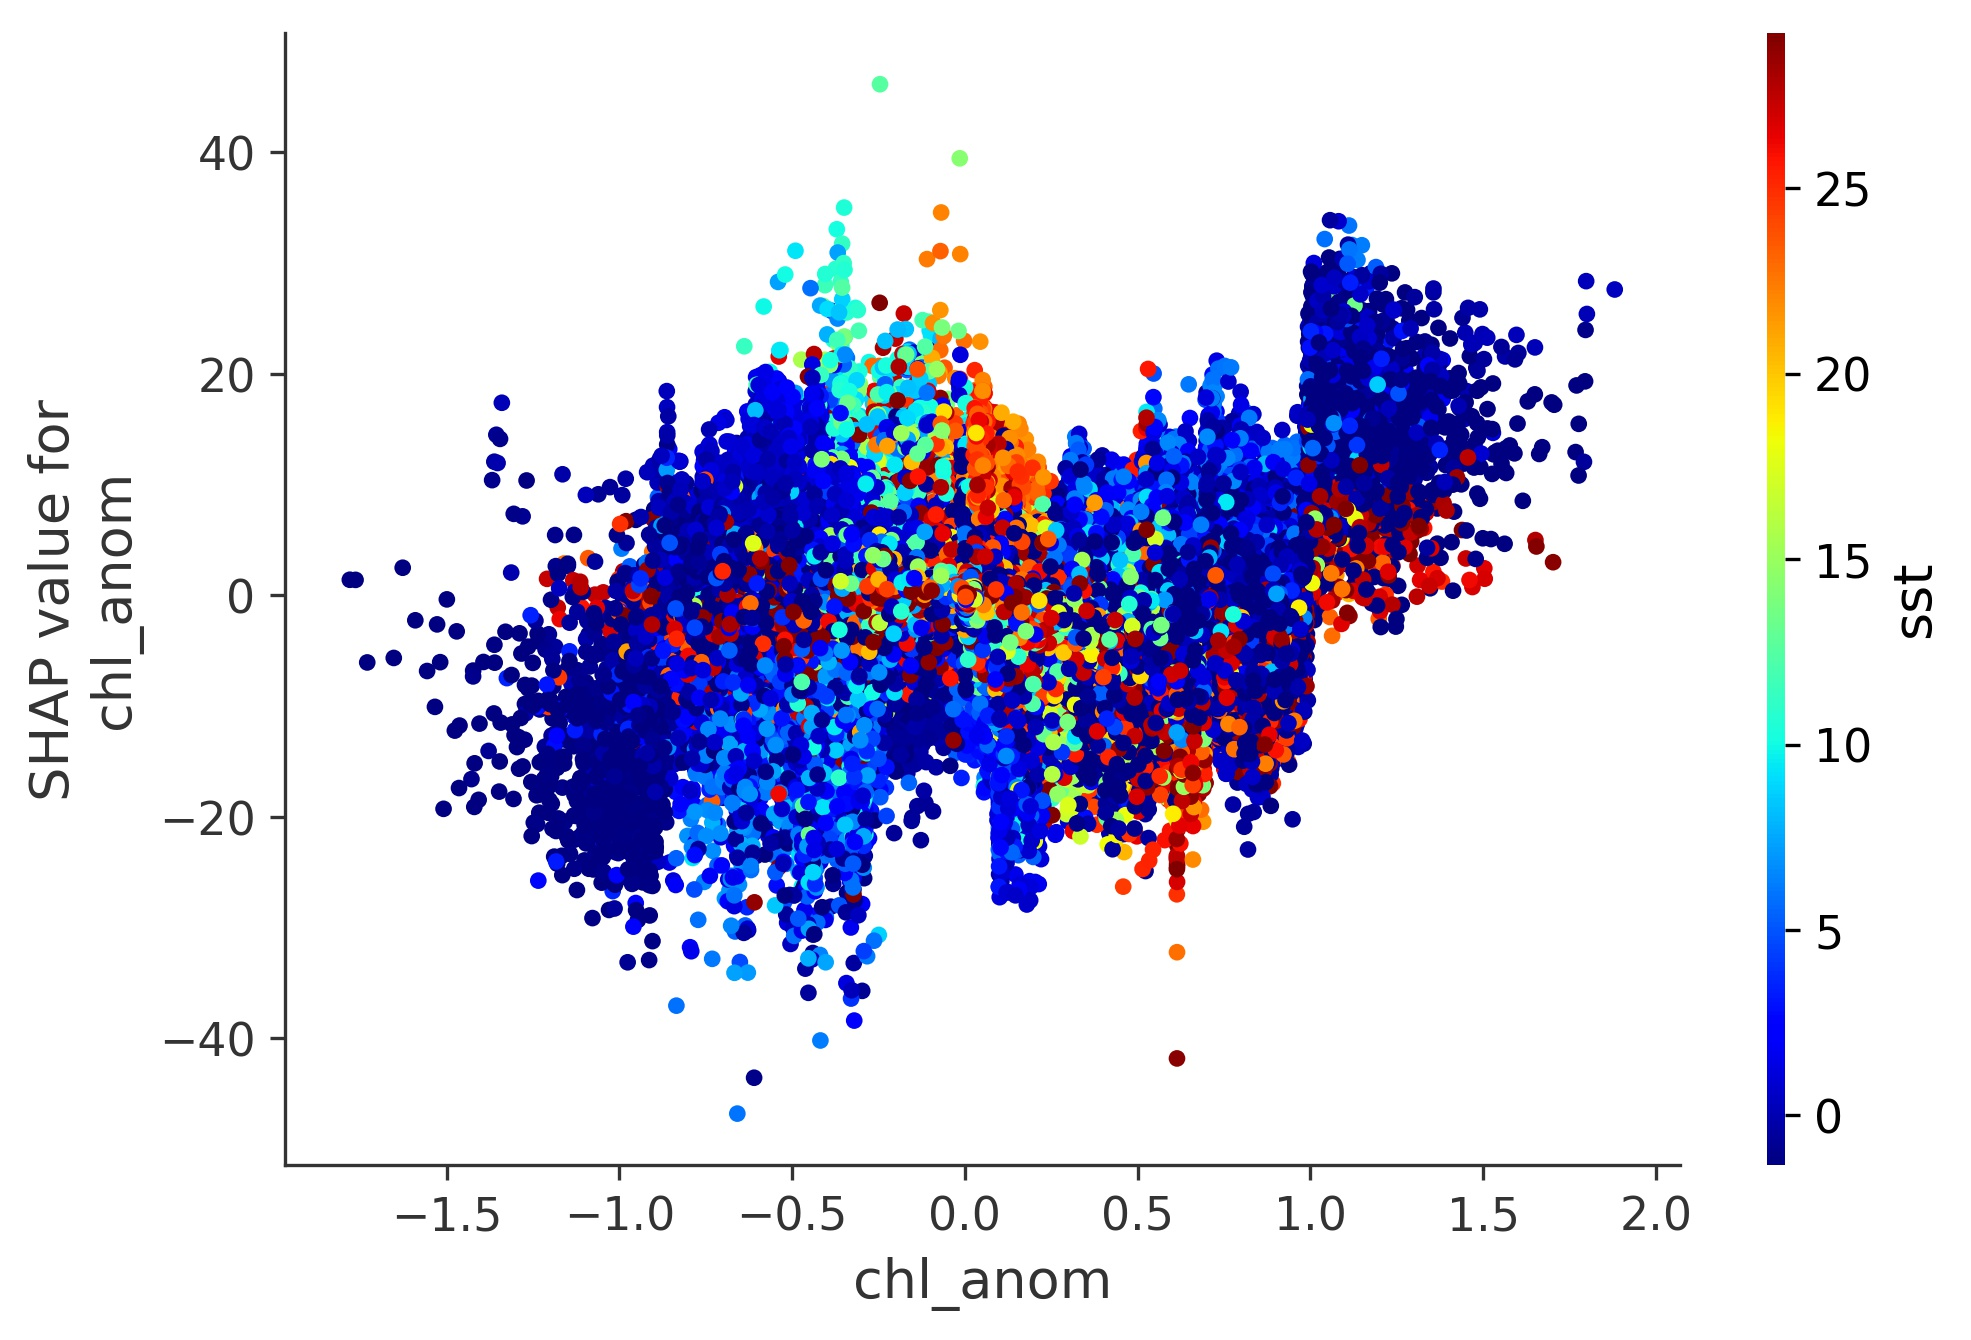

In [29]:
shap.dependence_plot(5, shap_unseen, X_recon,feature_names=feature_names,cmap='jet')

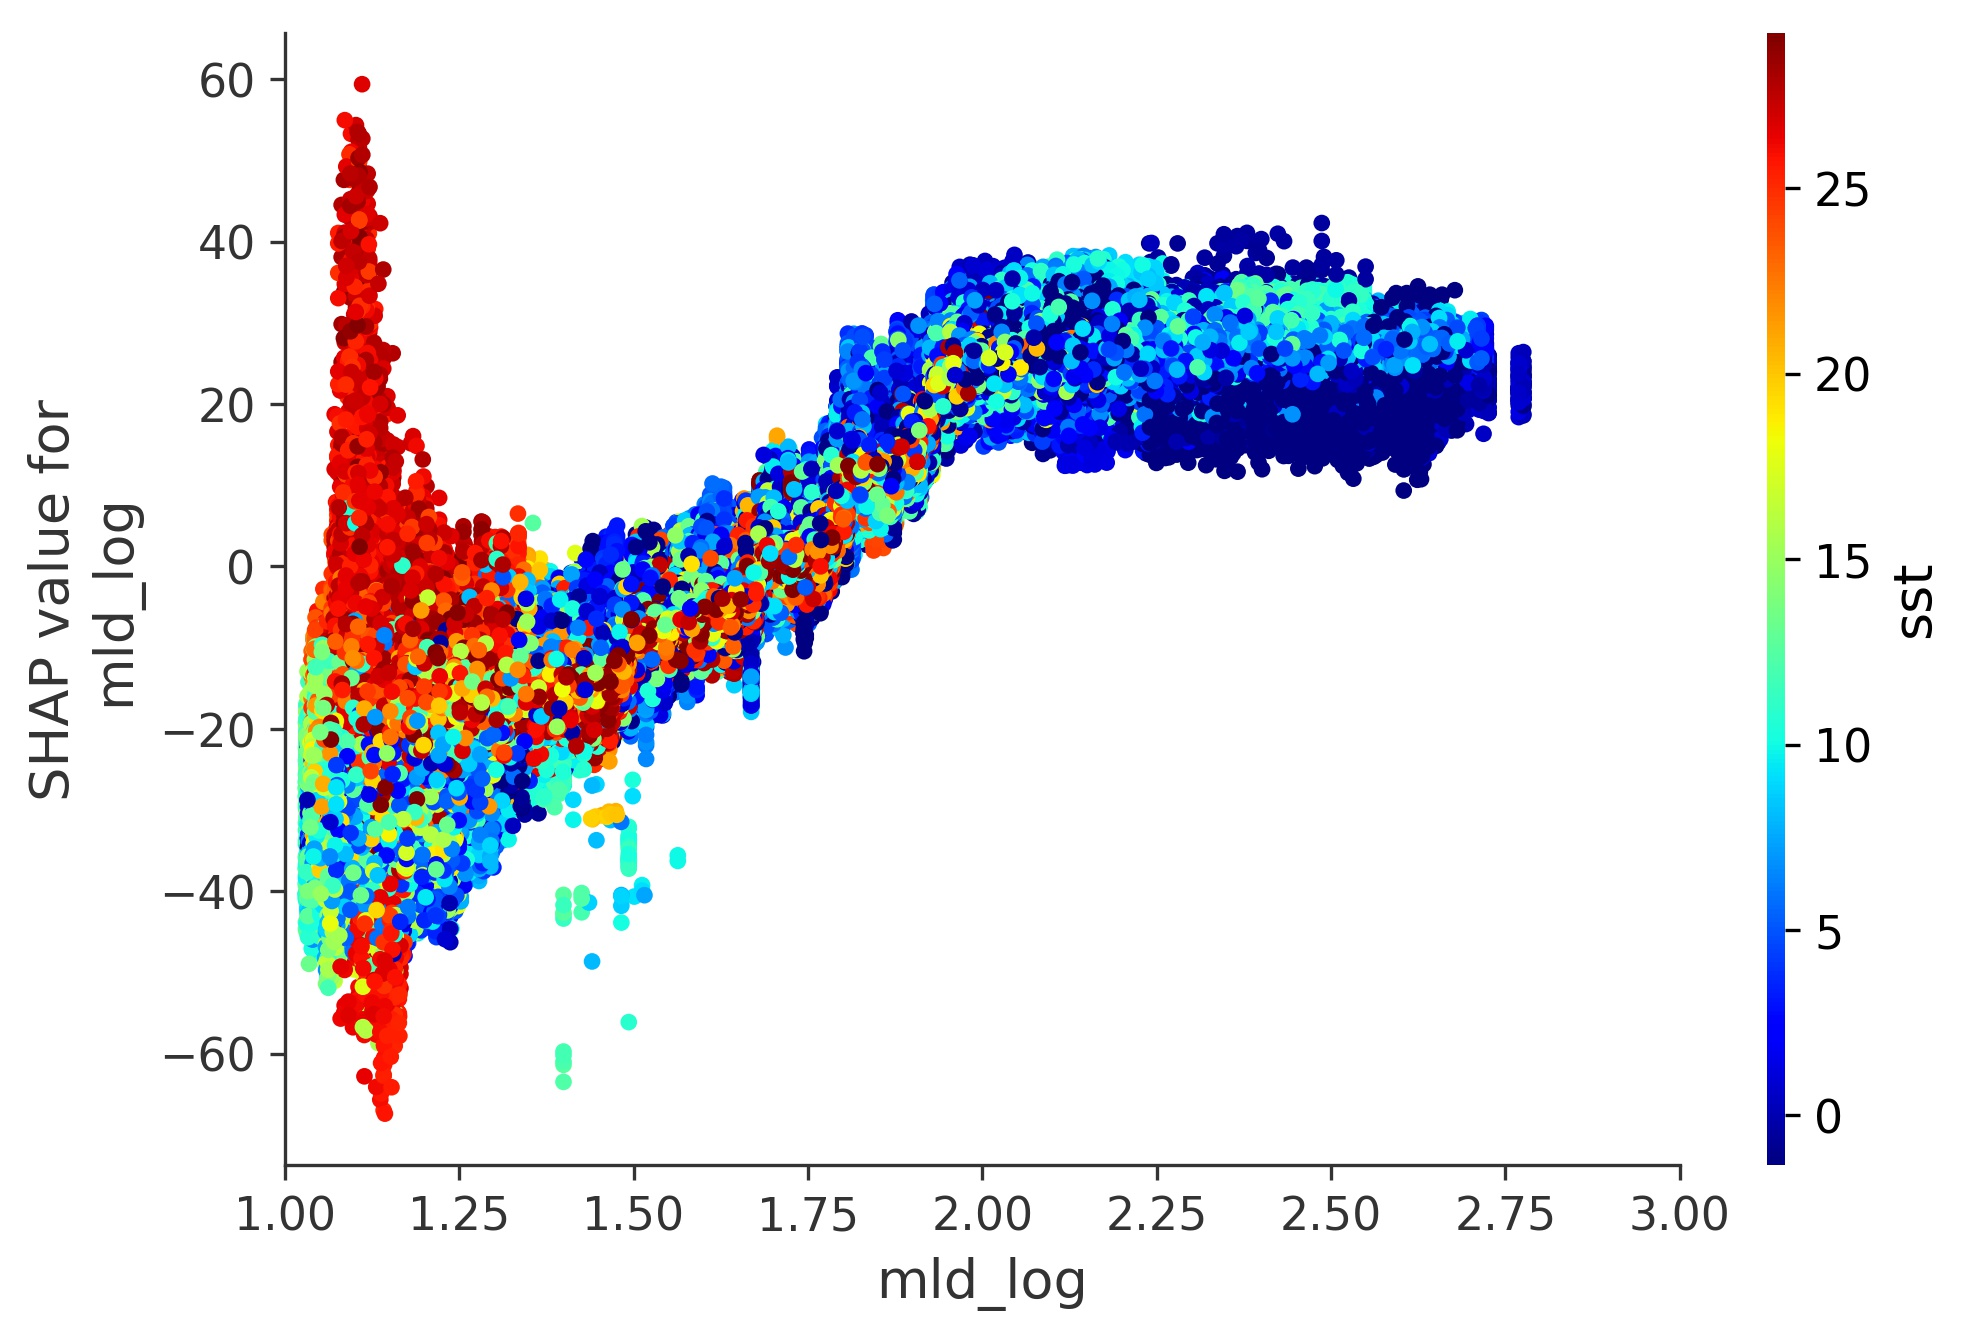

In [55]:
shap.dependence_plot(6, shap_unseen, X_recon,feature_names=feature_names,cmap='jet',xmin=1,xmax=3)

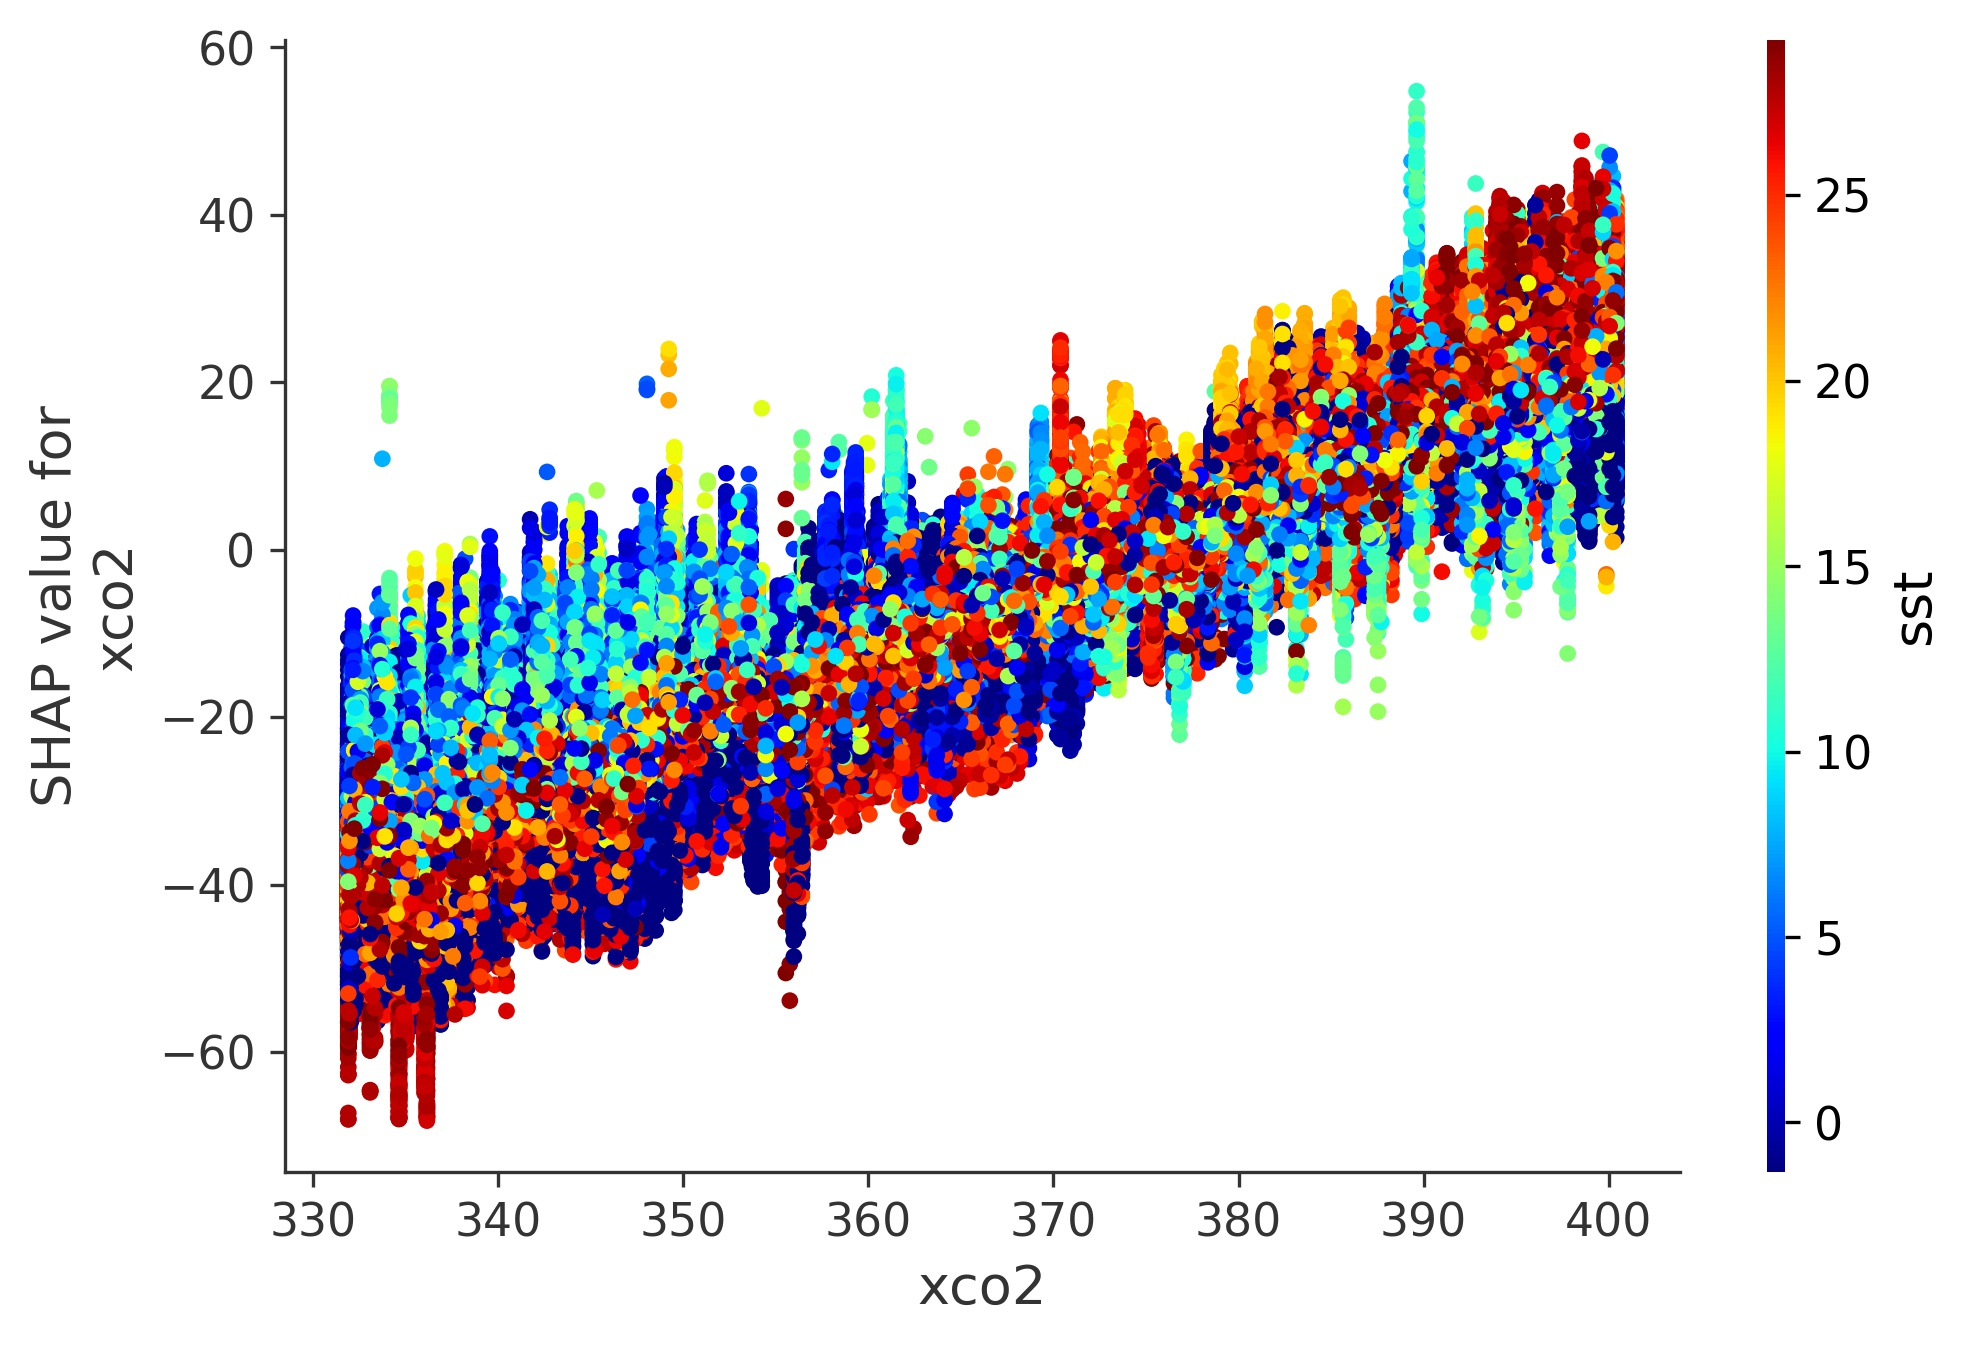

In [30]:
shap.dependence_plot(7, shap_unseen, X_recon,feature_names=feature_names,cmap='jet')

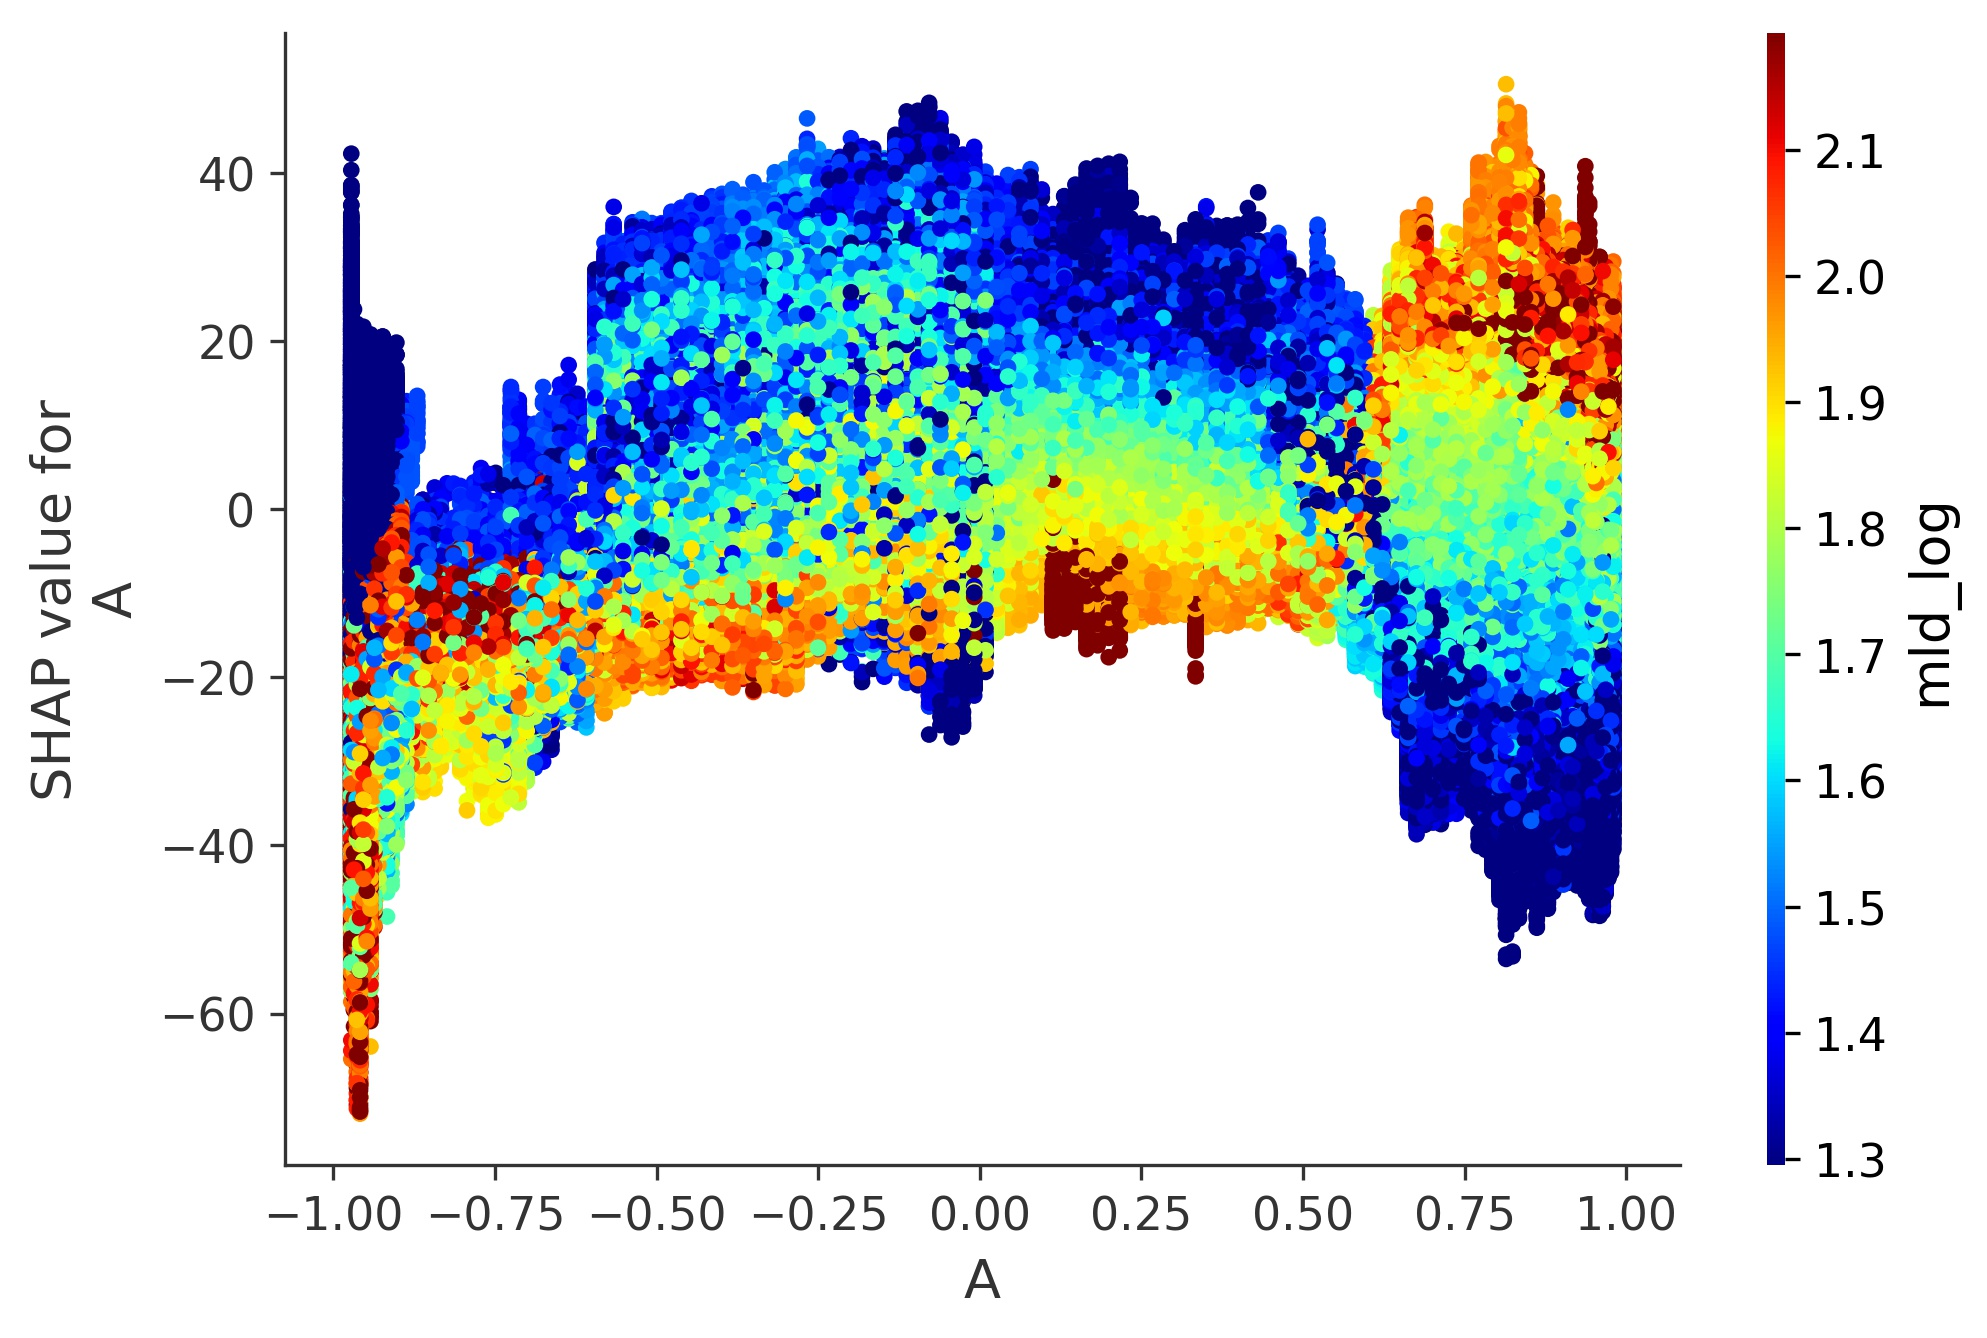

In [47]:
shap.dependence_plot(8, shap_unseen, X_recon,feature_names=feature_names,cmap='jet')

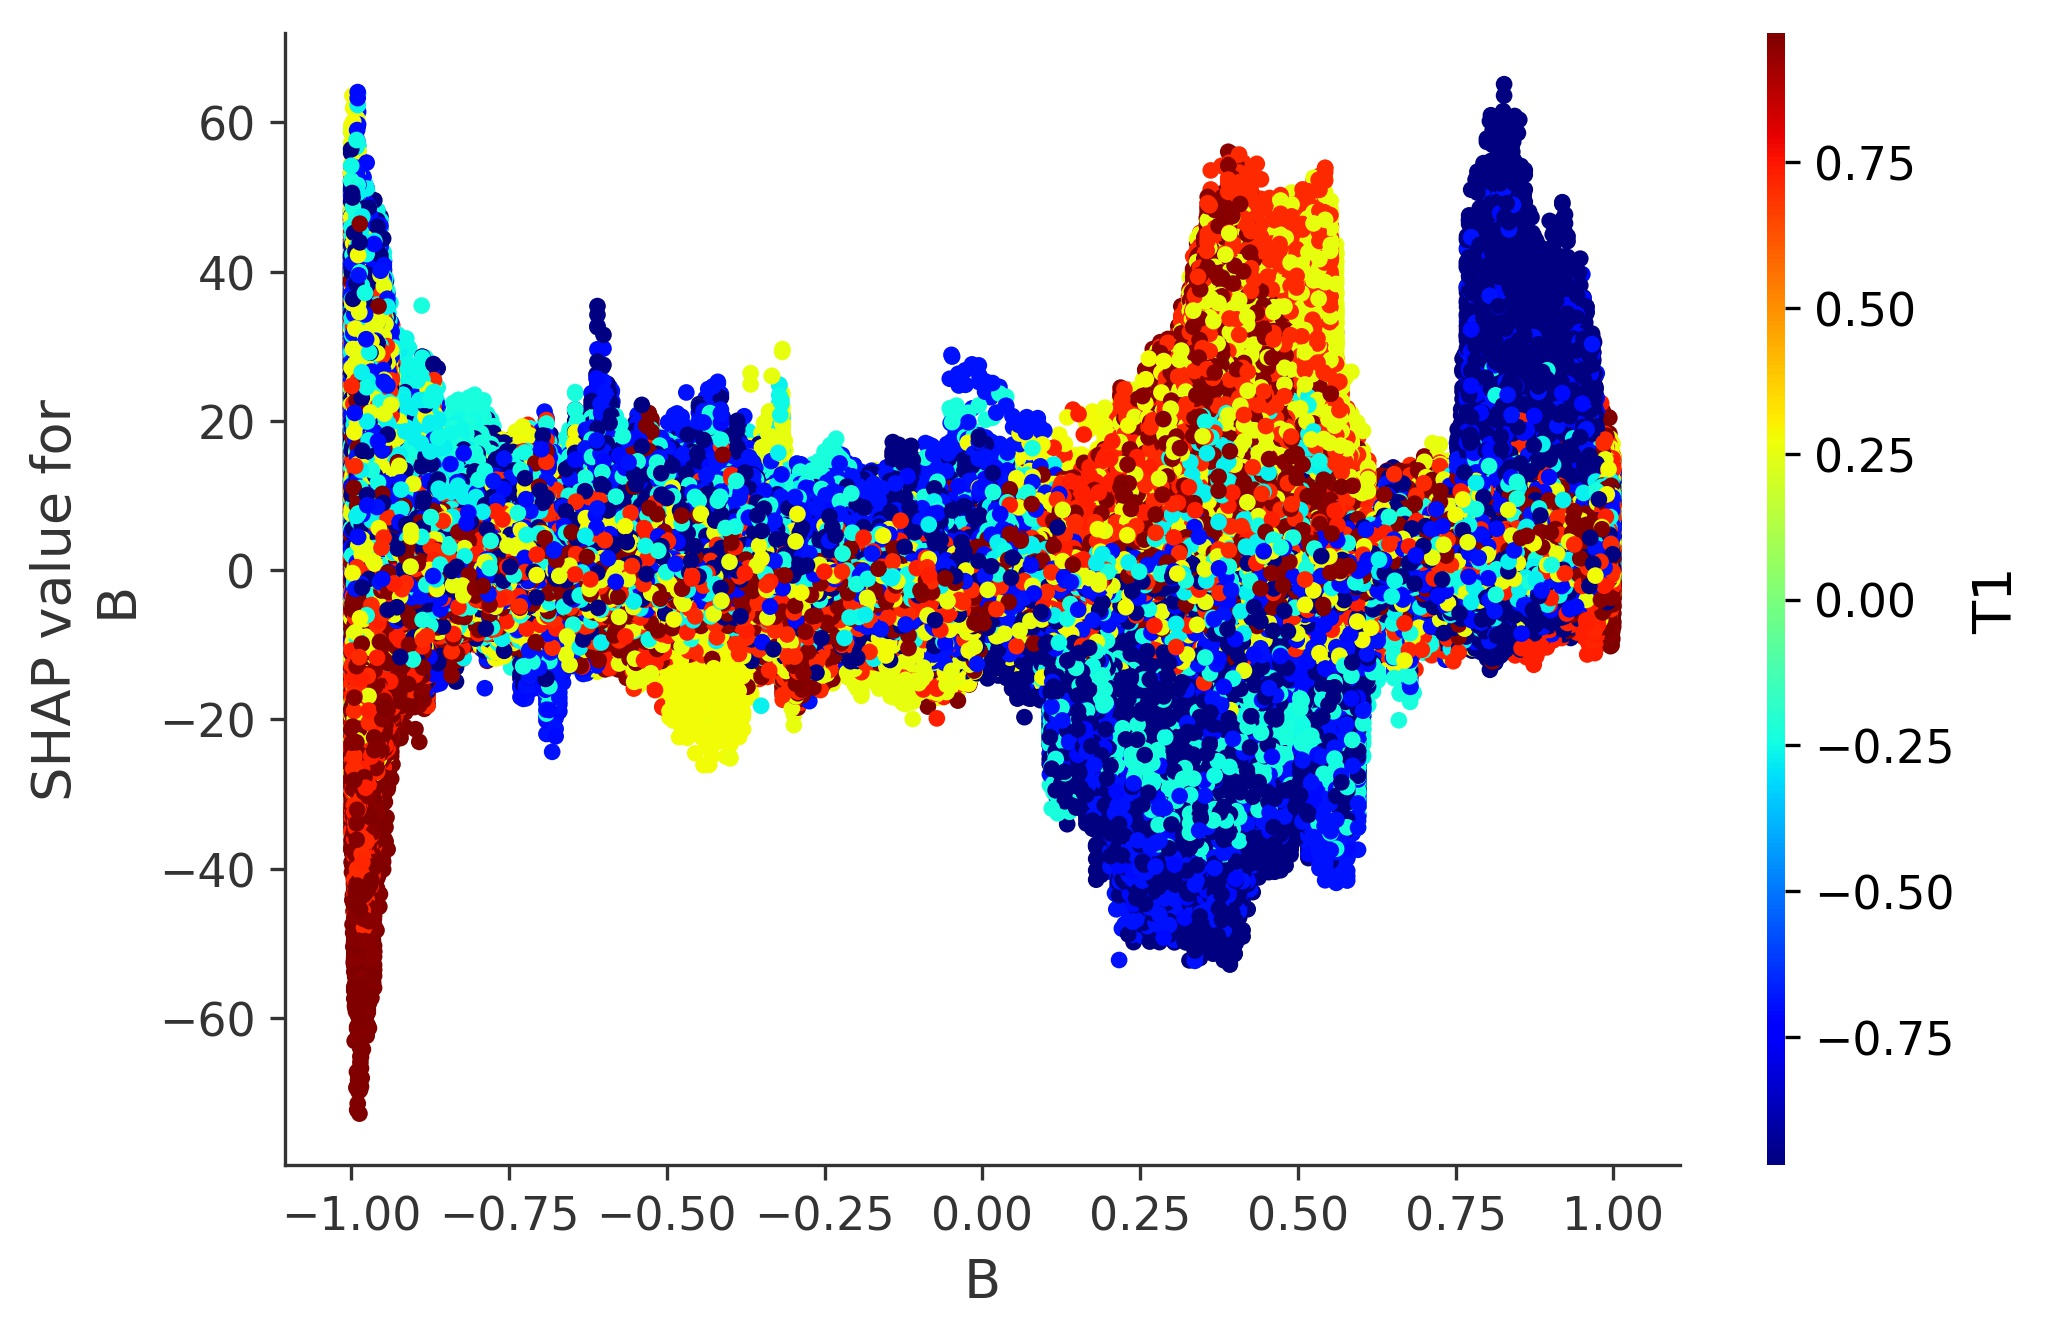

In [48]:
shap.dependence_plot(9, shap_unseen, X_recon,feature_names=feature_names,cmap='jet')

In [ ]:
### For final run, perhaps we want to map RMSE, pick out bad spots, and plot up feature importance for those areas?

Text(0.5,1,'Day of Year T0/T1 values')

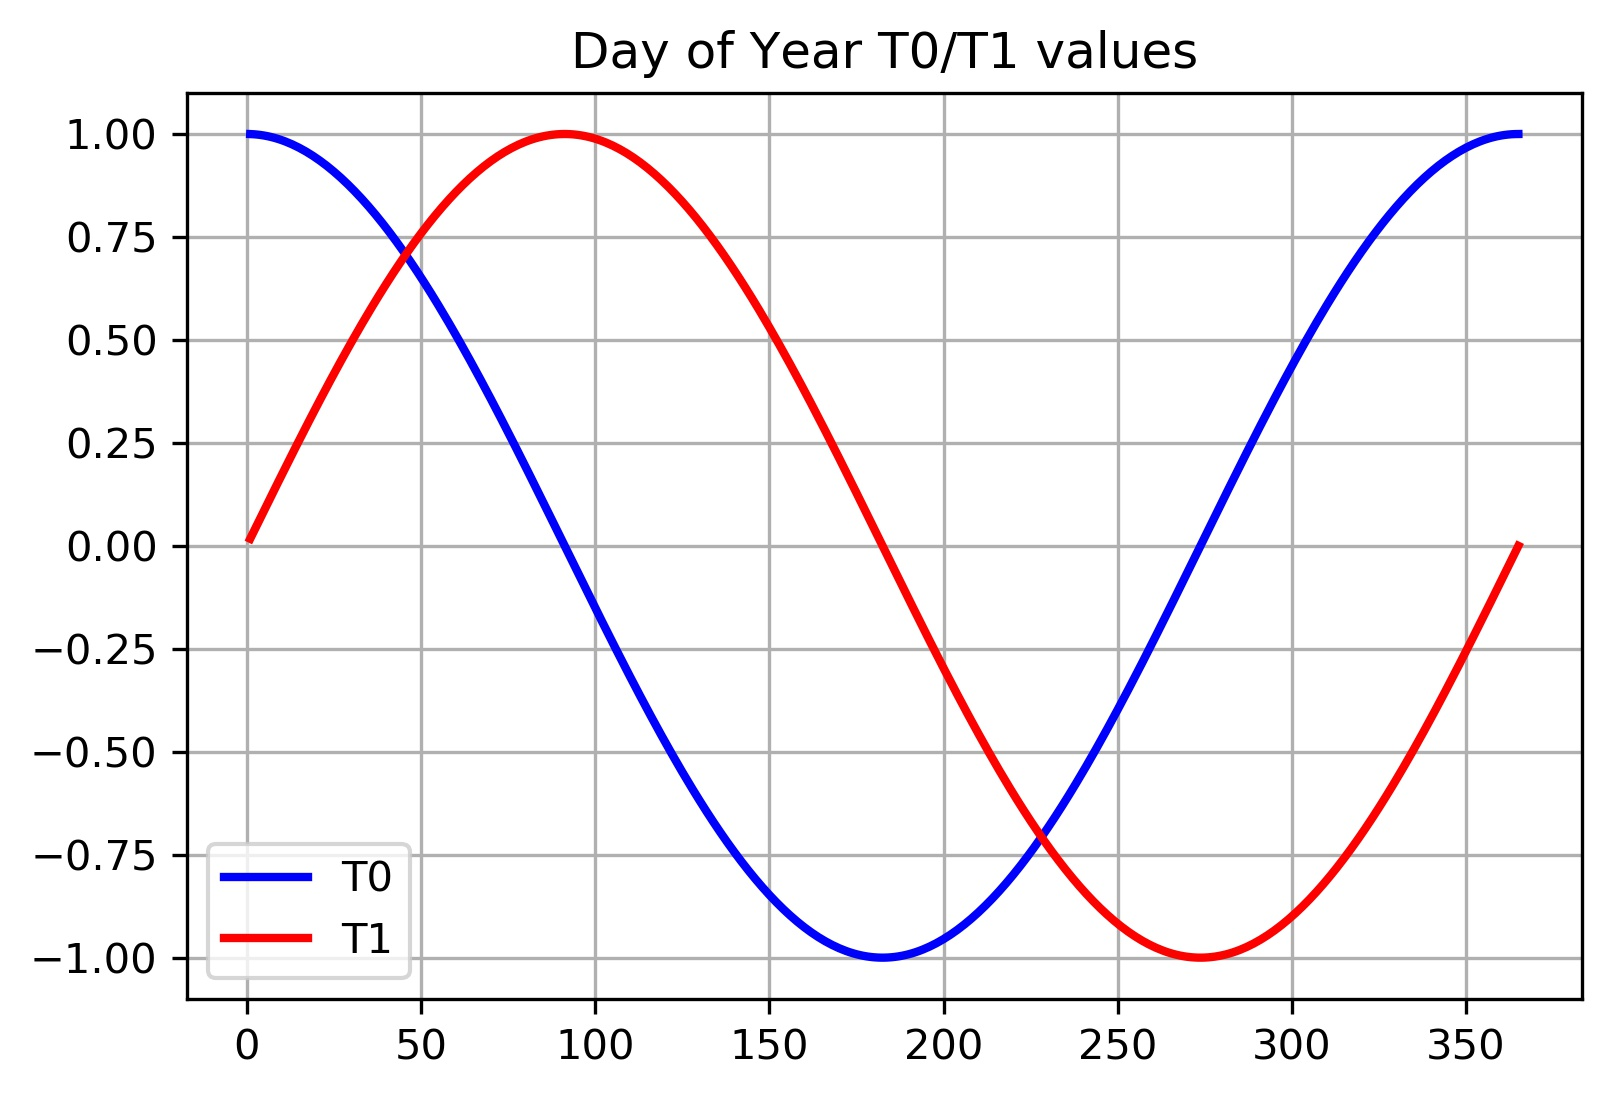

In [111]:
days_idx = np.empty(shape=[365])
for i in range(1,366):
    days_idx[i-1]=i
T0 = np.cos(days_idx * 2 * np.pi / 365)
T1 = np.sin(days_idx * 2 * np.pi / 365)

fig = plt.figure()
plt.plot(days_idx,T0,linewidth=2,color="blue")
plt.plot(days_idx,T1,linewidth=2,color="red")
plt.legend(["T0","T1"])
plt.grid(True)
plt.title("Day of Year T0/T1 values")

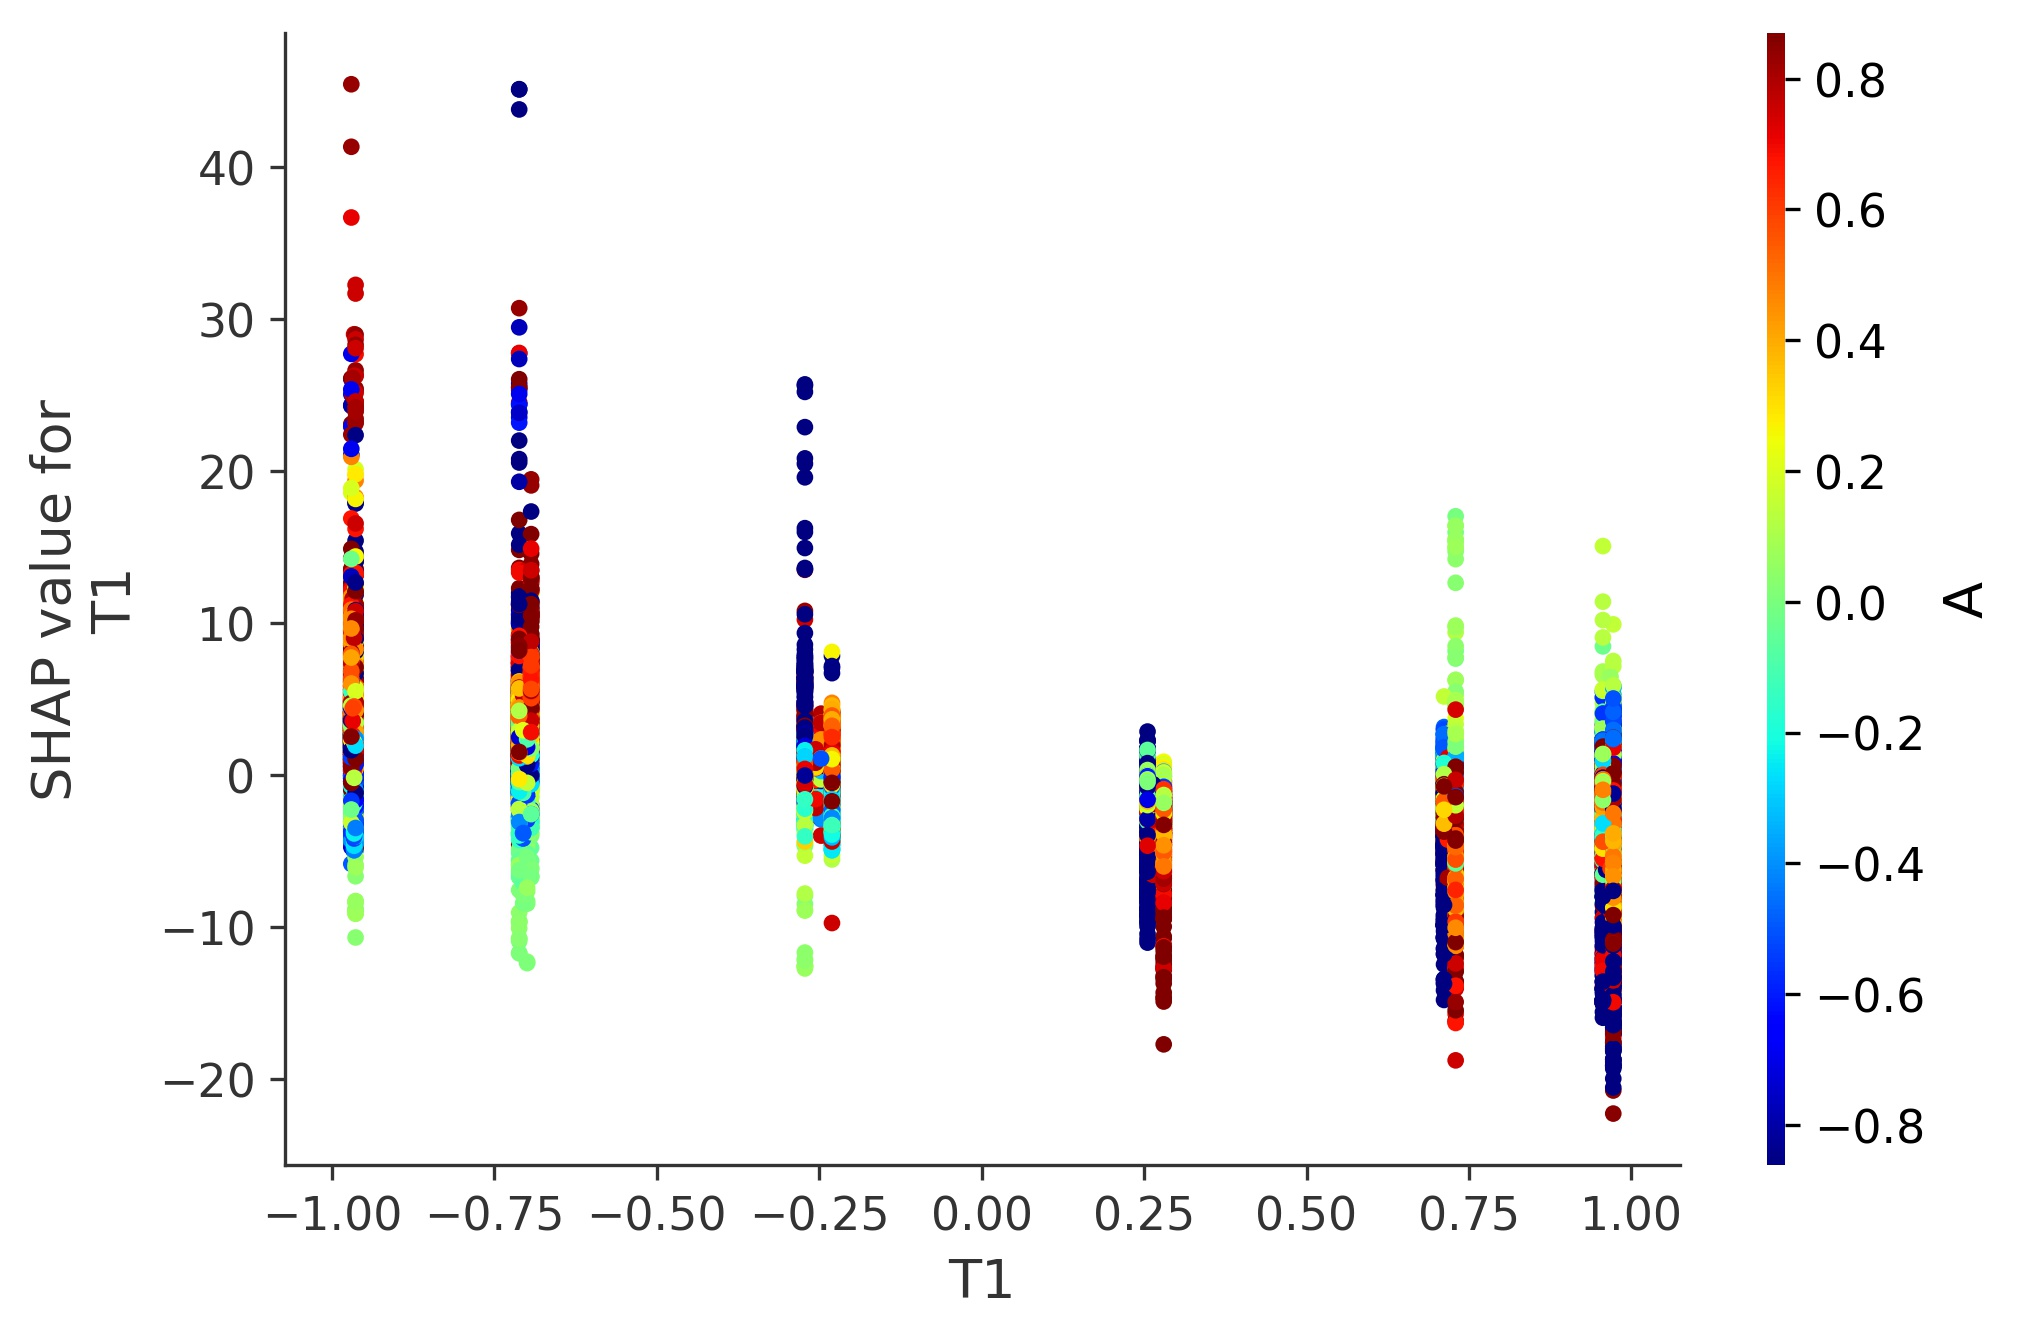

In [99]:
shap.dependence_plot(9, shap_values, X_test,feature_names=feature_names,cmap='jet',interaction_index="A")

In [90]:
# Reconstruct where no data ##########################################################
y_pred_nonsocat = model.predict(X_nonsocat)

# Everywhere, SOCAT and non-SOCAT ####################################################
y_recon = model.predict(X_recon)

# Just at SOCAT locations ############################################################
y_pred_socat = model.predict(X_socat)  

# Make room for our reconstruction:
df.drop(columns=['sss','sst','chl','mld','mld_log','chl_log','sss_anom','sst_anom'])

# Full reconstruction ##
df['dpco2_recon'] = np.nan
df.loc[recon_sel,['dpco2_recon']] = y_recon   

# All time/locations not sampled by SOCAT
df['dpco2_nonsocat'] = np.nan
df.loc[nonsocat_sel,['dpco2_nonsocat']] = y_pred_nonsocat
df.loc[sel,['dpco2_nonsocat']] = np.nan

# Only at time/locations of SOCAT sampling
df['dpco2_socat'] = np.nan
df.loc[sel,['dpco2_socat']] = y_pred_socat
df.loc[nonsocat_sel,['dpco2_socat']] = np.nan

df['dpco2_test_recon'] = np.nan
df.loc[test_sel,['dpco2_test_recon']] = y_pred_test

df['dpco2_test'] = np.nan
df.loc[test_sel,['dpco2_test']] = y_test
        
DS_recon = df[['net_mask','socat_mask','dpco2', 'dpco2_recon','dpco2_socat','dpco2_nonsocat','dpco2_test','dpco2_test_recon']].to_xarray()

########## SAVE ####################################################################################################
pre_SOCAT.save_recon(DS_recon, recon_output_dir, approach)   # Uncomment when actually running

print(datetime.datetime.now())

Starting reconstruction saving process
Save complete
2021-04-09 14:56:12.609735


In [92]:
# Saving best parameters and performance metrics
approach_output_dir = f"{other_output_dir}/{approach}"
param_fname = f"{approach_output_dir}/{approach}_best_params_dict.pickle"
test_perform_fname = f"{approach_output_dir}/{approach}_test_performance_dict.pickle"

Path(approach_output_dir).mkdir(parents=True, exist_ok=True)

with open(param_fname, 'wb') as handle:
    pickle.dump(best_params, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(test_perform_fname, 'wb') as handle:
    pickle.dump(test_performance, handle)
    
# Convert performance metrics to dataframes
test_df = pd.DataFrame.from_dict(test_performance,
                                 orient='index')

# Save the dataframes too
test_df_fname = f"{approach_output_dir}/{approach}_test_performance_df.pickle"

test_df.to_pickle(test_df_fname)